In [1]:
import scipy
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow import keras
from Levenshtein import *
from seq_diff import diff_html


In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

In [3]:
with np.load('data/transcriptase/train_cut.npz', allow_pickle = True) as data:
    X = data['parents']
    Y = data['children']
    V = data['vocab_index'].tolist()

In [4]:
model = keras.models.load_model("./models/transcriptase_6_atmesta")
model

2022-08-12 09:53:33.747313: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-12 09:53:33.747349: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ai
2022-08-12 09:53:33.747354: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ai
2022-08-12 09:53:33.747414: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.85.2
2022-08-12 09:53:33.747429: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.85.2
2022-08-12 09:53:33.747433: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.85.2
2022-08-12 09:53:33.747593: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-

In [5]:
token_index = V
reverse_char_index = dict((i, char) for char, i in token_index.items())
decode_seq = lambda seq: [ ''.join([ reverse_char_index[i] for i in s ]) for s in np.argmax(seq, axis = 2)]
legit_values = [decoded_x.startswith('PISP') and decoded_y.startswith('PISP')   for decoded_x, decoded_y  in zip(decode_seq(X), decode_seq(Y))]

In [6]:
np.where(np.array(legit_values)==False)

(array([    0,     1,     2, ..., 17197, 17198, 17207]),)

In [7]:
i = 2
x1 = decode_seq(X[i:i+1,:,:])[0]
y1 = decode_seq(Y[i:i+1,:,:])[0]
_ = diff_html(x1, y1, display_a=True, display_b=True)

In [9]:
yp1 = decode_seq(model.predict([ X[i:i+1,:,:], np.array([0.01])]))[0]

_ = diff_html(x1, yp1, display_a=True, display_b=True)

1/1 [==============================] - 0s 385ms/step


In [10]:
cce = tf.keras.losses.CategoricalCrossentropy()


In [11]:
cce(np.array(X[legit_values], dtype=np.float32),np.array(Y[legit_values], dtype=np.float32))

<tf.Tensor: shape=(), dtype=float32, numpy=0.52692205>

In [12]:
ce_0 = 0.52692205

In [13]:
X = X[legit_values]
Y = Y[legit_values]

In [26]:
rand_rates = []
for r in tqdm(np.arange(0.00, 1, 0.05)):
    tf.keras.backend.clear_session()
    Y_pred = model.predict([X, np.full((len(X)), r)])
    cc = keras.losses.CategoricalCrossentropy()(X, Y_pred).numpy()
    rand_rates.append([r, cc])
rand_rates = np.array(rand_rates)

  0%|          | 0/20 [00:00<?, ?it/s]

422/422 [==============================] - 1s 3ms/step


  0%|          | 0/20 [00:00<?, ?it/s]

 21/422 [>.............................] - ETA: 1s 


KeyboardInterrupt



In [108]:
from scipy.optimize import curve_fit
func = lambda t, a, b, c, d: a * t**3 + b * t**2 + c * t + d
p, _ = curve_fit(func, rand_rates[:,0],  rand_rates[:,1])

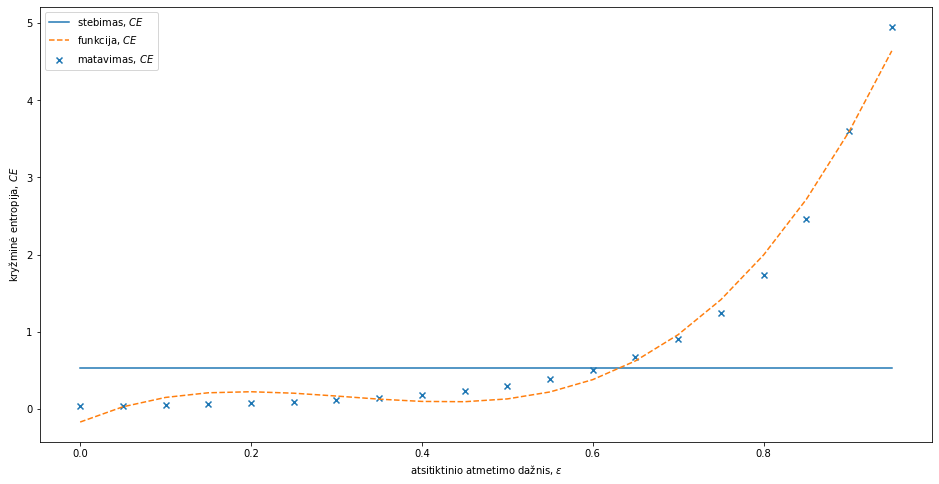

In [109]:
plt.plot(rand_rates[:,0], np.full_like(rand_rates[:,1], ce_0), label="stebimas, $CE$")
plt.plot(rand_rates[:,0], func(rand_rates[:,0], p[0], p[1], p[2], p[3]), '--', label="funkcija, $CE$")
plt.scatter(rand_rates[:,0], rand_rates[:,1], marker='x', label="matavimas, $CE$")
plt.ylabel('kryžminė entropija, $CE$')
plt.xlabel('atsitiktinio atmetimo dažnis, $ε$')

plt.legend()
plt.show()

In [110]:
p, _ = curve_fit(func, rand_rates[:,1],  rand_rates[:,0])
epsilon = func(ce_0, p[0], p[1], p[2], p[3])
print([f'{j:0.5f}' for i,j in enumerate(p)])
epsilon

['0.03923', '-0.34487', '0.91368', '0.14728']


0.538708241062535

In [46]:
Y_predictions = model.predict([ X, np.full(X.shape[0],0)], verbose=0)

In [47]:
df_true = pd.DataFrame({'parent':list(''.join(decode_seq(X))),'child':list(''.join(decode_seq(Y)))})
df_true['count'] = 1
df_true_mutations = df_true.loc[df_true['parent']!=df_true['child']]
df_true_frequencies = pd.pivot_table(df_true_mutations, values='count', index='parent',columns='child',aggfunc='count')
for key in V:
    if key not in df_true_frequencies:
        df_true_frequencies[key] = np.NaN
df_true_frequencies = df_true_frequencies[sorted(V.keys())]


In [48]:
df_pred = pd.DataFrame({'parent':list(''.join(decode_seq(X))),'child':list(''.join(decode_seq(Y_predictions)))})
df_pred['count'] = 1
df_pred_mutations = df_pred.loc[df_pred['parent']!=df_pred['child']]
df_pred_frequencies = pd.pivot_table(df_pred_mutations, values='count', index='parent',columns='child',aggfunc='count')
for key in V:
    if key not in df_pred_frequencies:
        df_pred_frequencies[key] = np.NaN
df_pred_frequencies = df_pred_frequencies[sorted(V.keys())]
        

In [49]:
import seaborn as sns

<AxesSubplot:xlabel='child', ylabel='parent'>

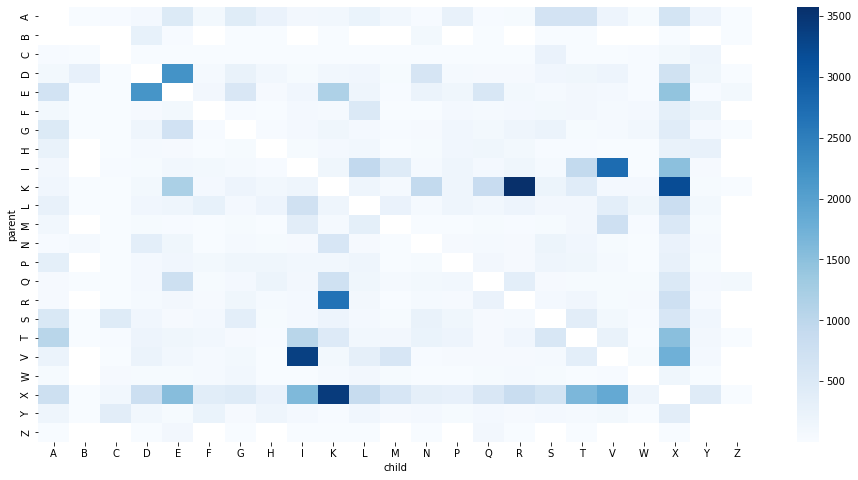

In [50]:
sns.heatmap(df_true_frequencies, cmap='Blues',)

<AxesSubplot:xlabel='child', ylabel='parent'>

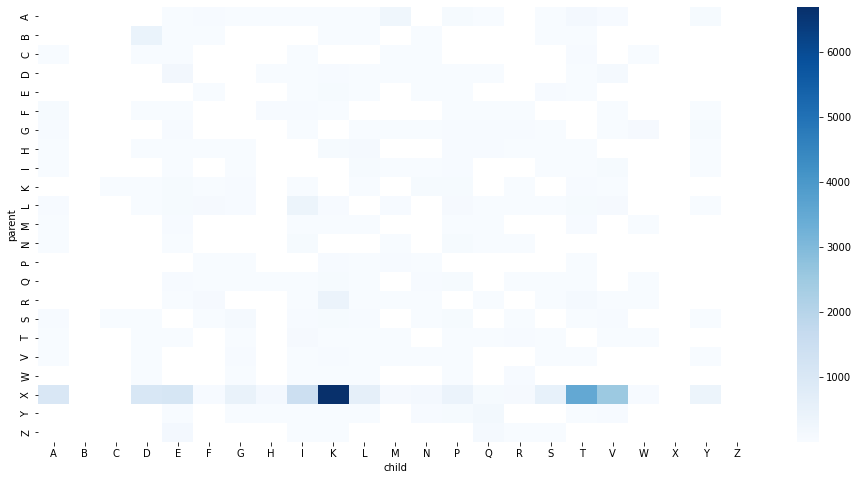

In [51]:
sns.heatmap(df_pred_frequencies, cmap='Blues',)

In [48]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

def plot(df_true, df_pred, idx, normalize=False, sort=False,polyorder=0, sortby='index', title=None):
    if title is None:
        title = f'{idx} amino acid mutation.'
    if sortby not in ['index','prediction']:
        raise ValueError('Can only sort by "index" or "prediction"')
    df_true_loc = df_true.loc[idx].to_frame()
    df_pred_loc = df_pred.loc[idx].to_frame().add_suffix('_pred')
    df = pd.concat([df_true_loc,df_pred_loc],axis=1)
    df= df.fillna(0)
    if normalize:
        scaler = MinMaxScaler()
        scaler = scaler.fit(df)
        df[[idx,f'{idx}_pred']]=scaler.transform(df)
        title += 'Normalized values.'
        df['diff'] = (df[idx] - df[f'{idx}_pred']).abs()
        df['max'] = df[[idx,f'{idx}_pred']].values.max(axis=1)
        scaled_diff = (df.loc[df['max']!=0,'diff']/df.loc[df['max']!=0,'max']).values.mean()
        title += f'Scaled difference: {scaled_diff:0.3f}'
    if sort:
        sortval = idx
        if sortby == 'prediction':
            sortval = f'{idx}_pred'
        df = df.sort_values(by=sortval,ascending=False)
    if sort and normalize and polyorder>0:
        poly = np.poly1d(np.polyfit(np.arange(len(df)), df[idx].values, polyorder))
        poly_pred = np.poly1d(np.polyfit(np.arange(len(df)), df[f'{idx}_pred'].values, polyorder))
        xp = np.linspace(0, len(df), 1000)
        plt.plot(xp, poly(xp), '-')
        plt.plot(xp, poly_pred(xp), '--')
        ax = plt.gca()
        df[[idx,f'{idx}_pred']].plot.bar(ax=ax)
        plt.ylim(0,1.1)
    else:
        df[[idx,f'{idx}_pred']].plot.bar()
        ax = plt.gca()
        # recompute the ax.dataLim
        ax.relim()
        # update ax.viewLim using the new dataLim
        ax.autoscale_view()
    plt.title(title)
    plt.show()
    
# df_all_frequencies.loc['A'].to_frame()

In [49]:
def calculate_diff(df_true, df_pred, idx):
    df_true_loc = df_true.loc[idx].to_frame()
    df_pred_loc = df_pred.loc[idx].to_frame().add_suffix('_pred')
    df = pd.concat([df_true_loc,df_pred_loc],axis=1)
    normalized=''
    scaler = MinMaxScaler()
    scaler = scaler.fit(df)
    df[[idx,f'{idx}_pred']]=scaler.transform(df)
    normalized=' normalized'
    return mean_squared_error(df[idx].fillna(0), df[f'{idx}_pred'].fillna(0))


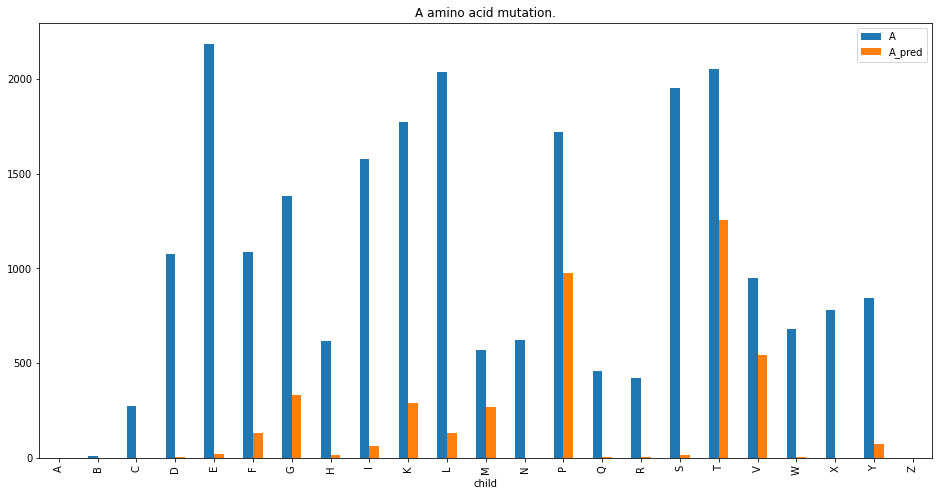

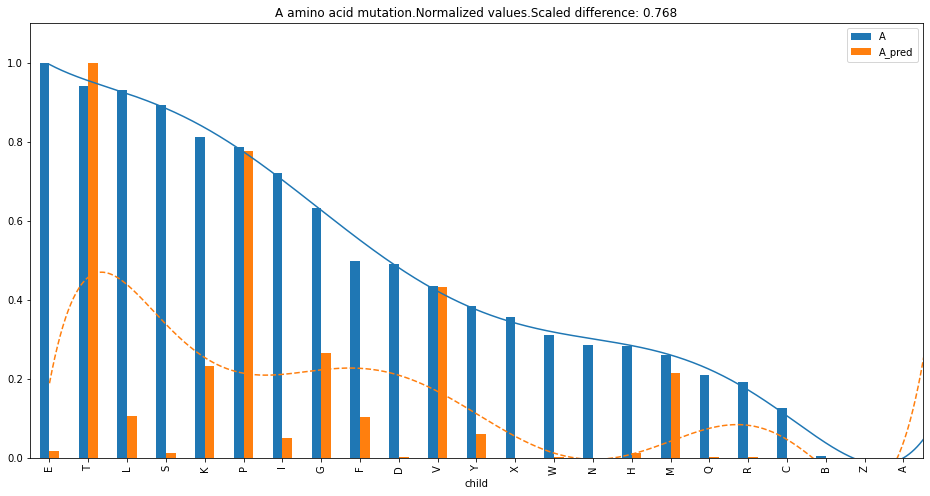

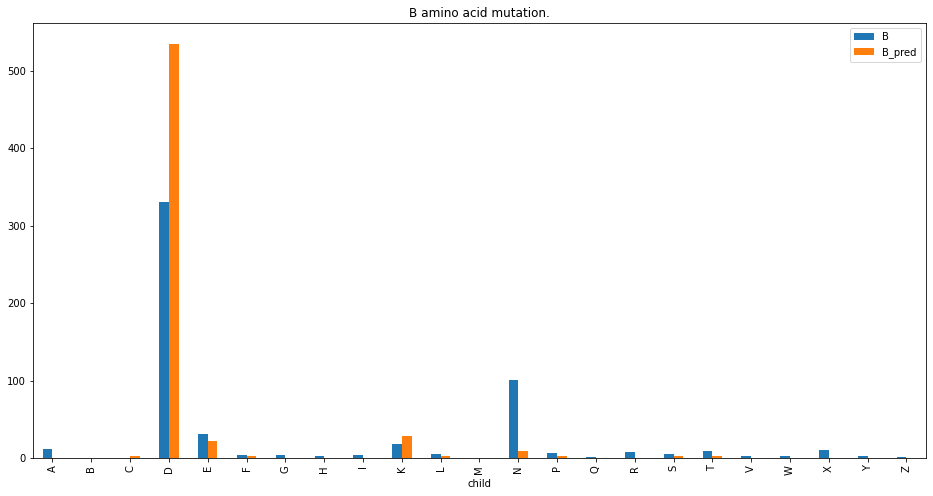

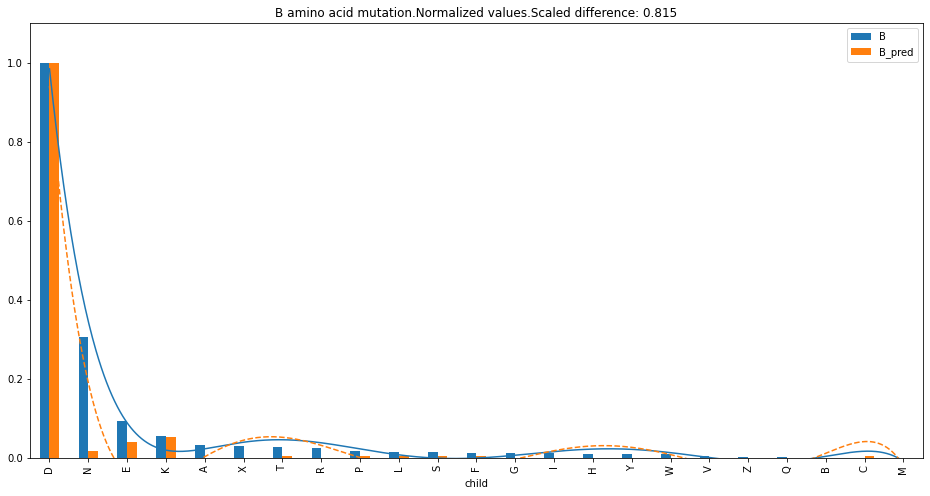

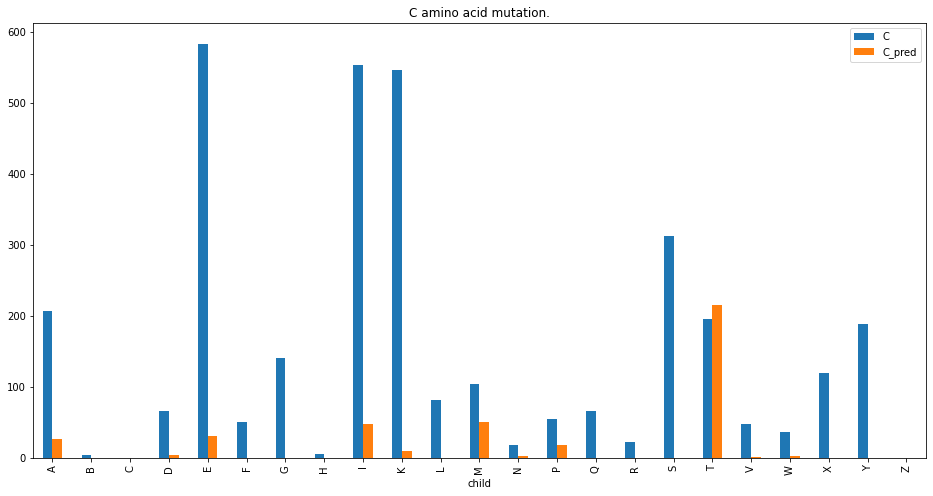

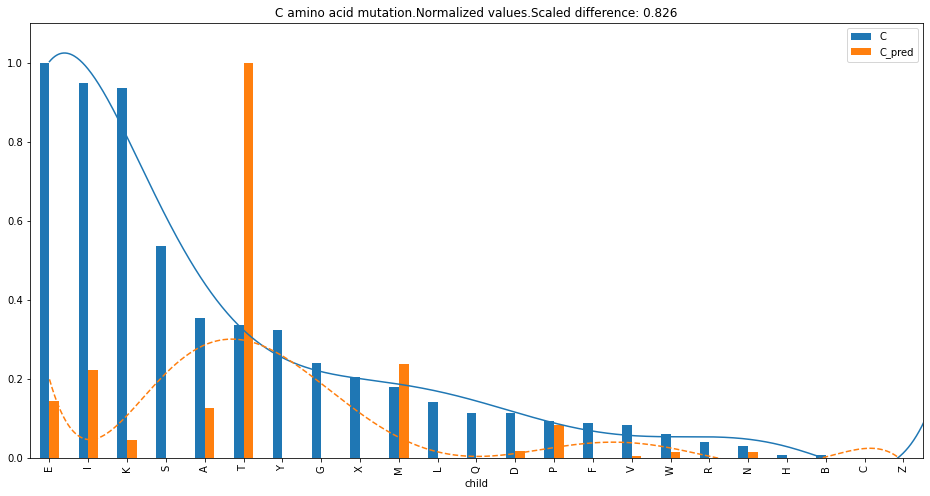

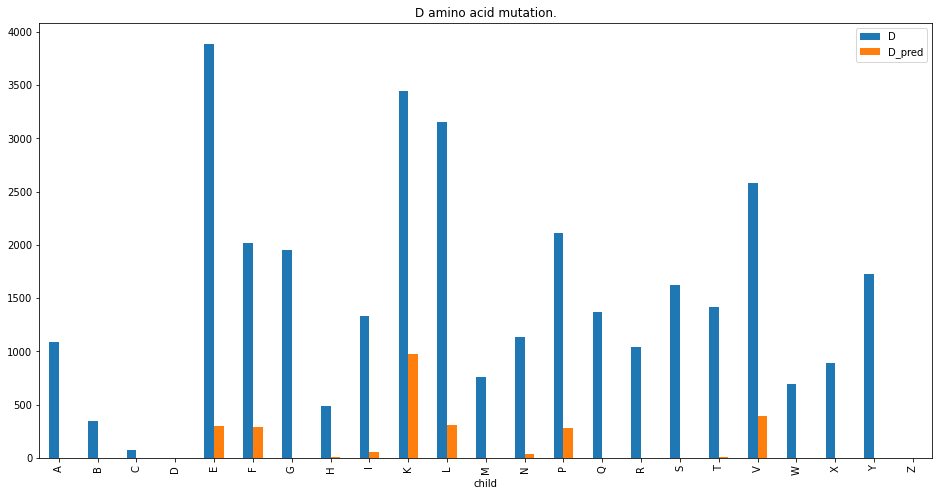

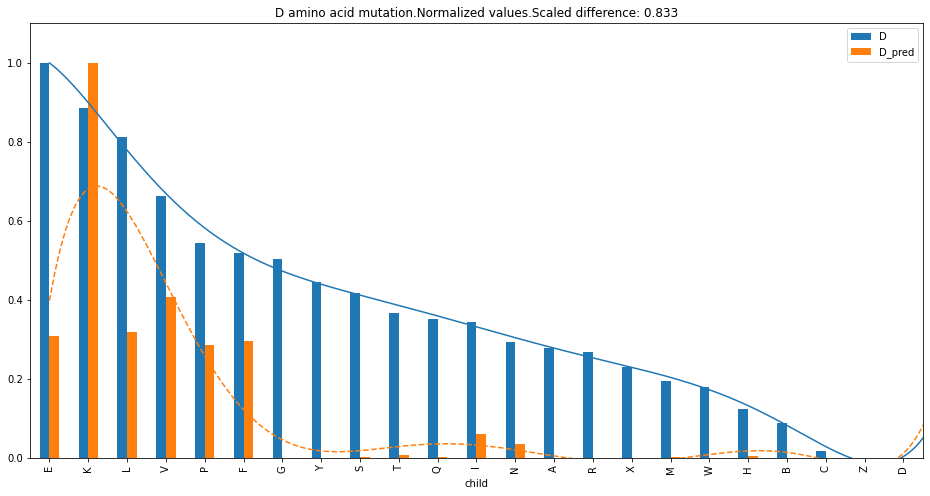

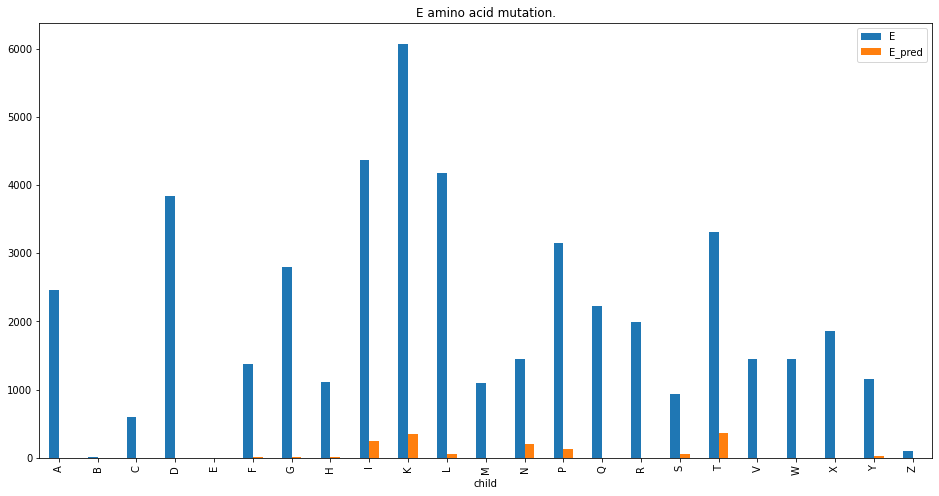

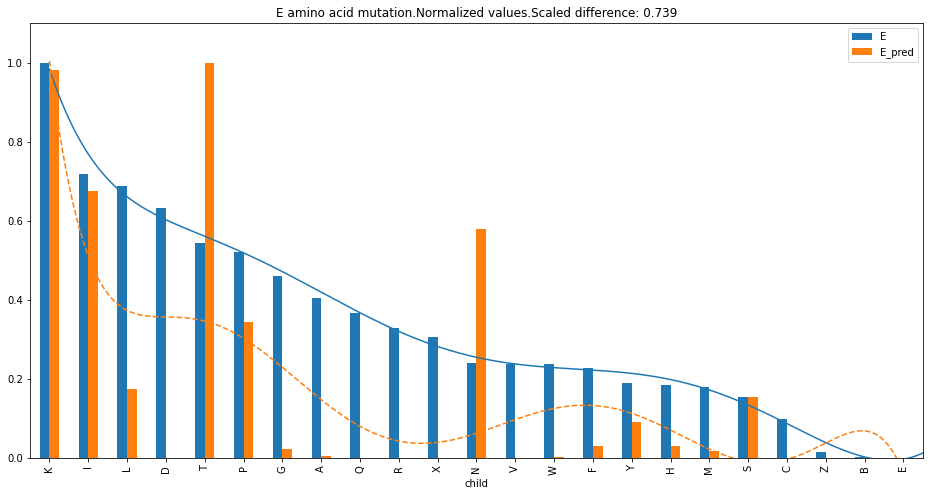

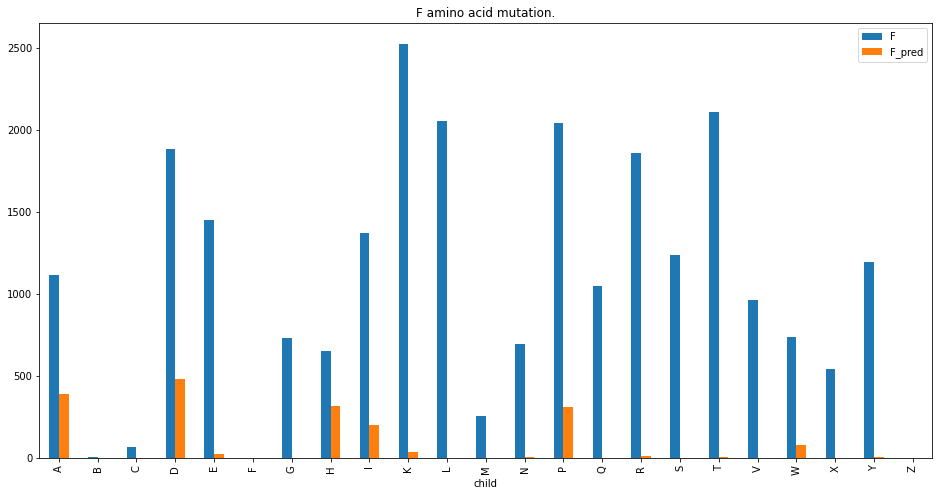

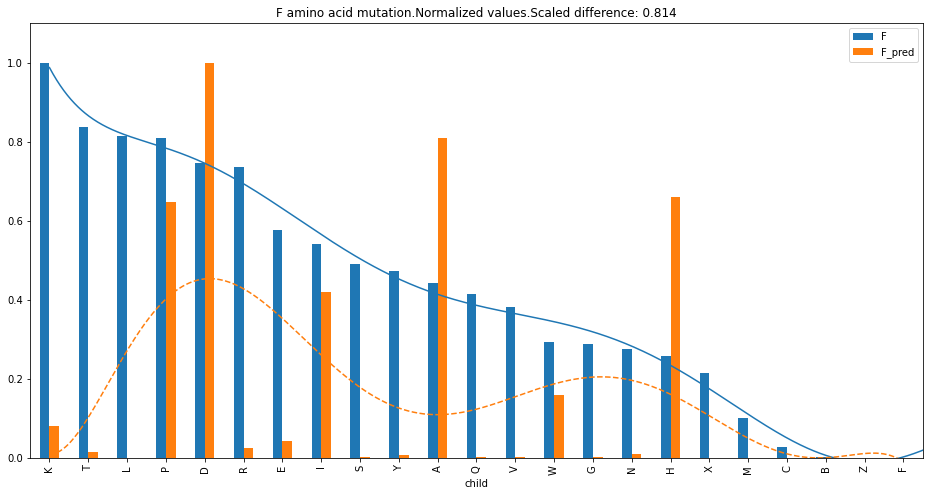

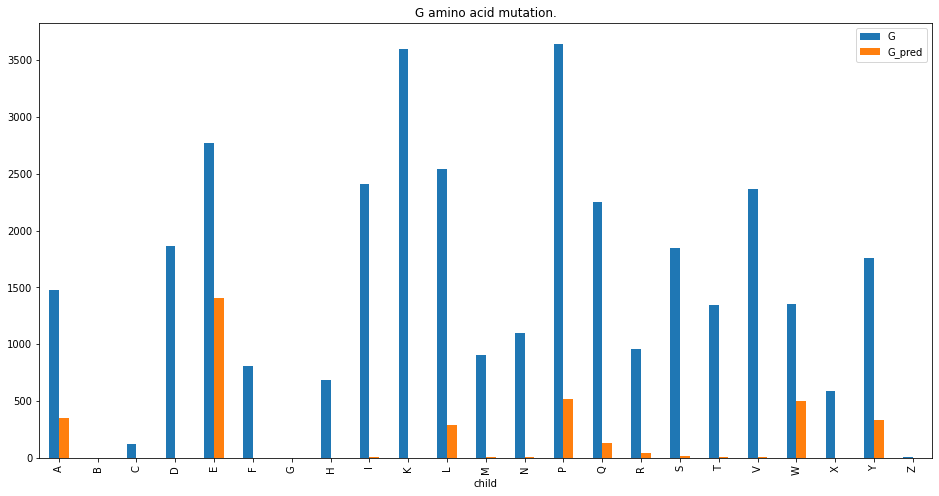

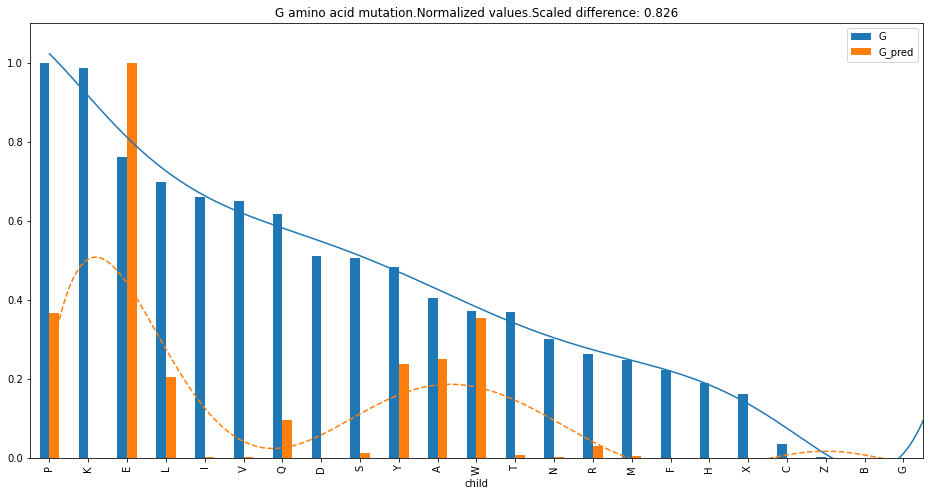

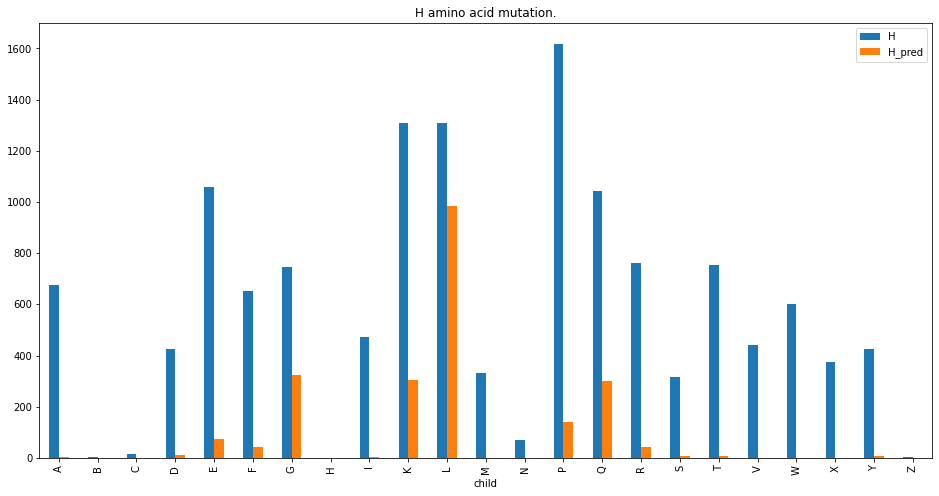

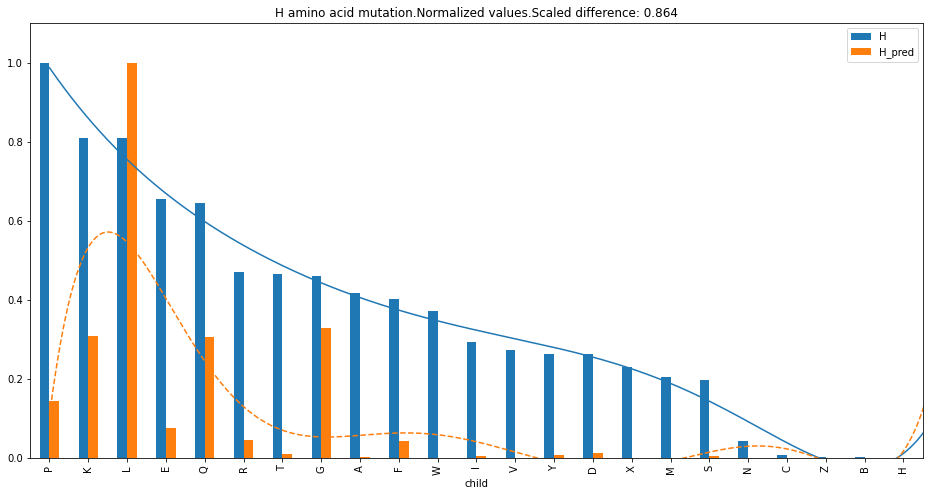

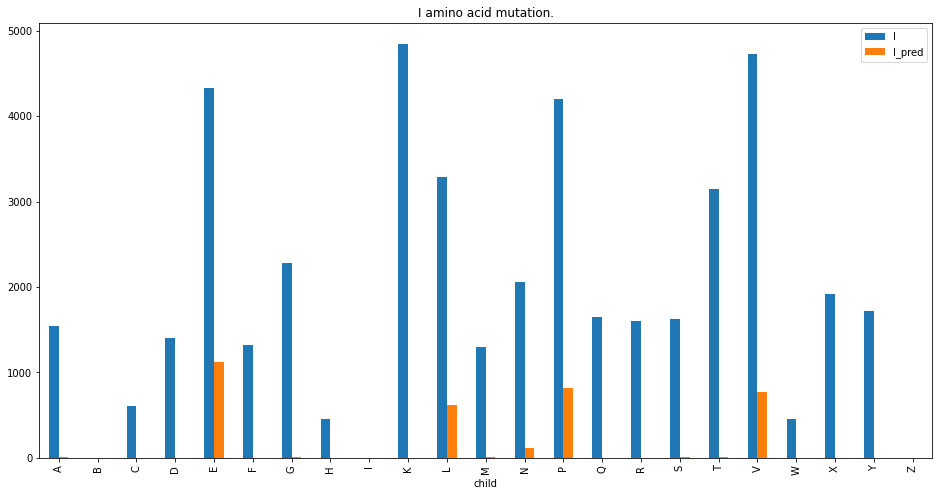

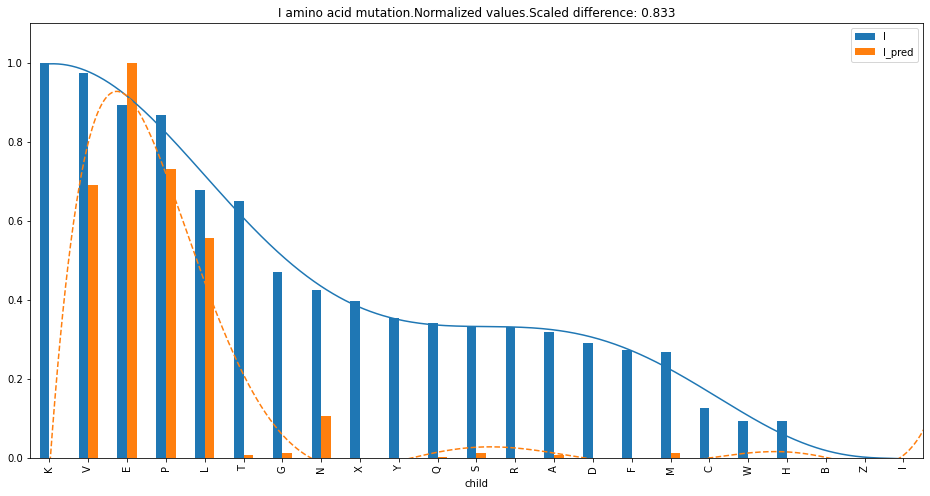

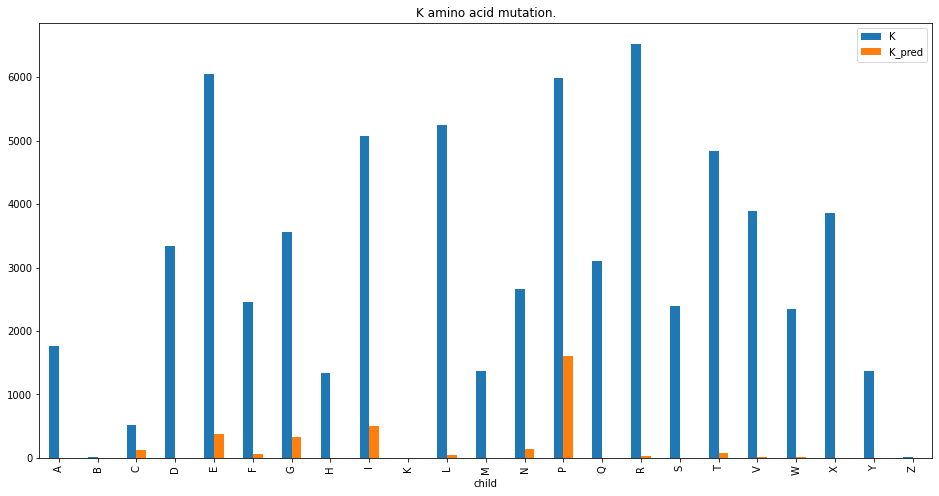

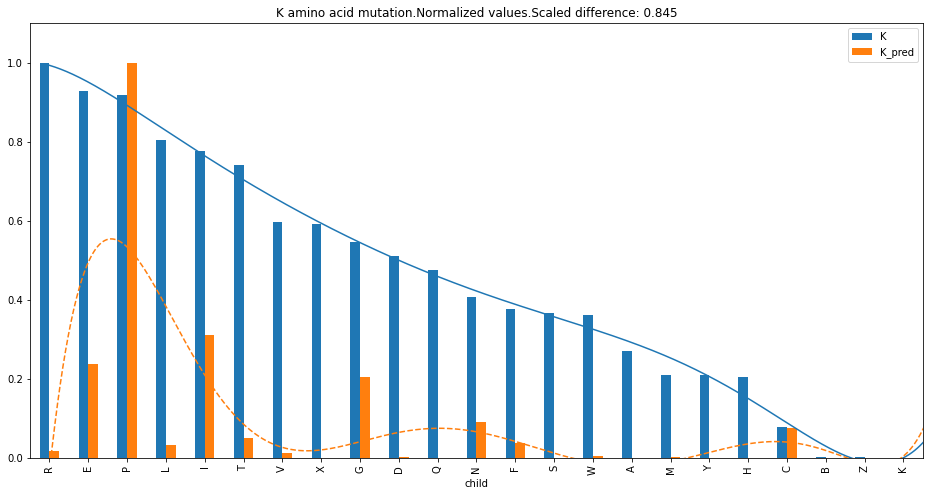

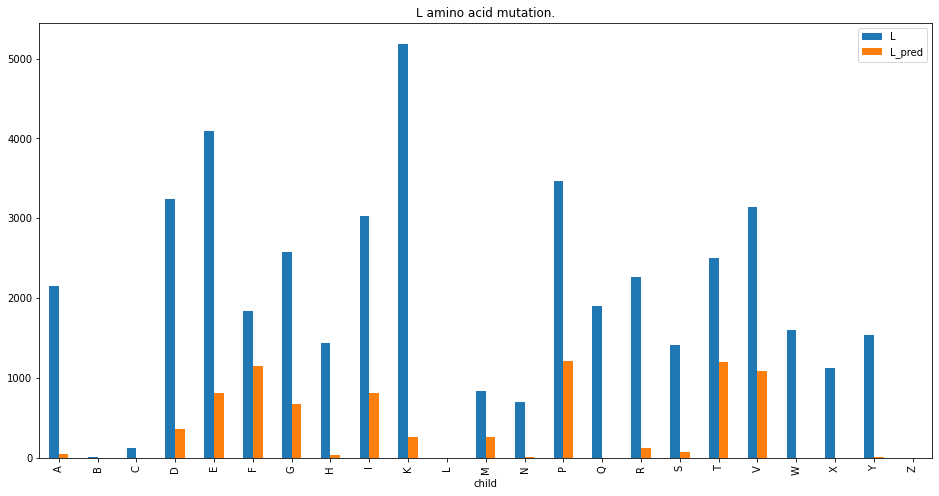

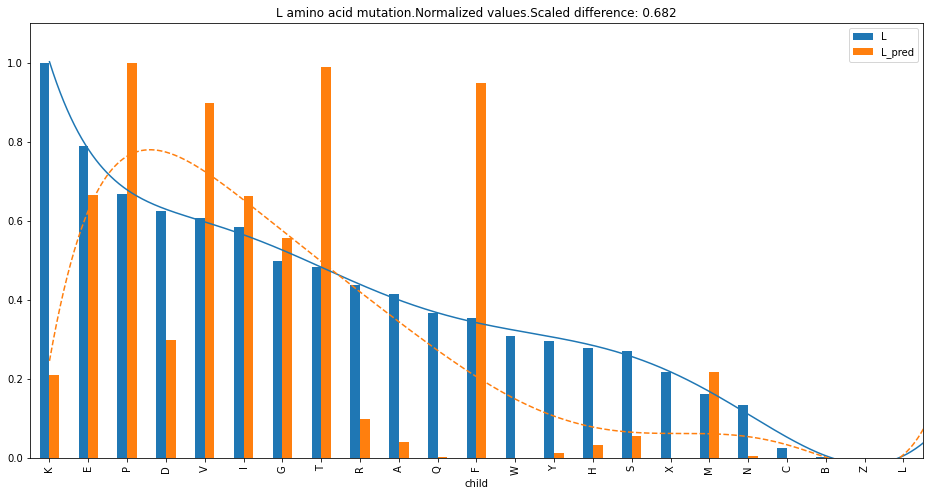

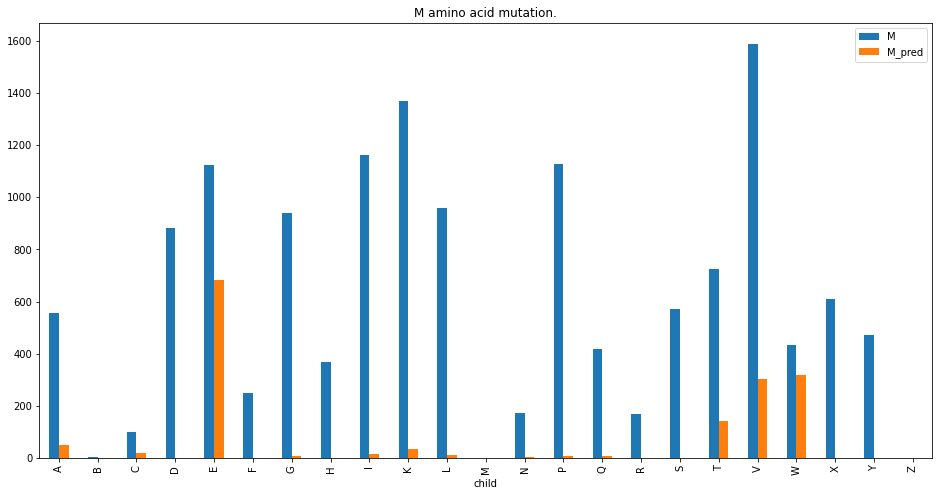

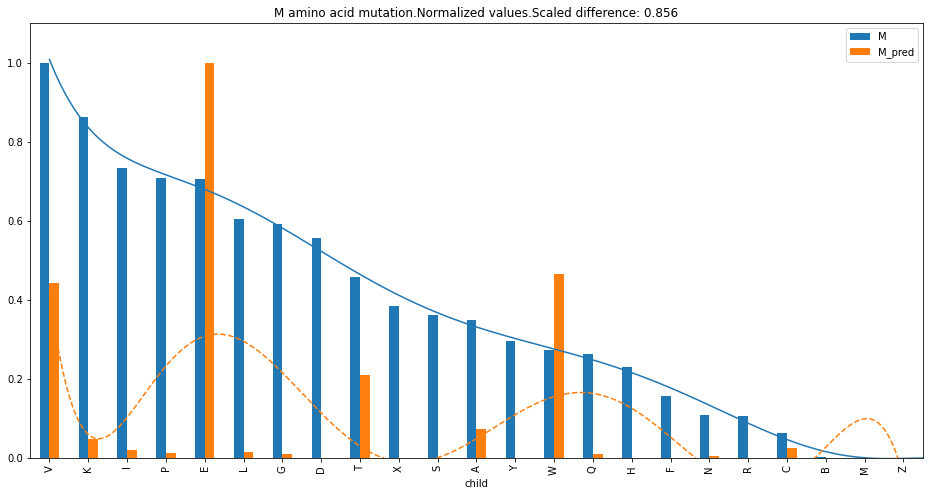

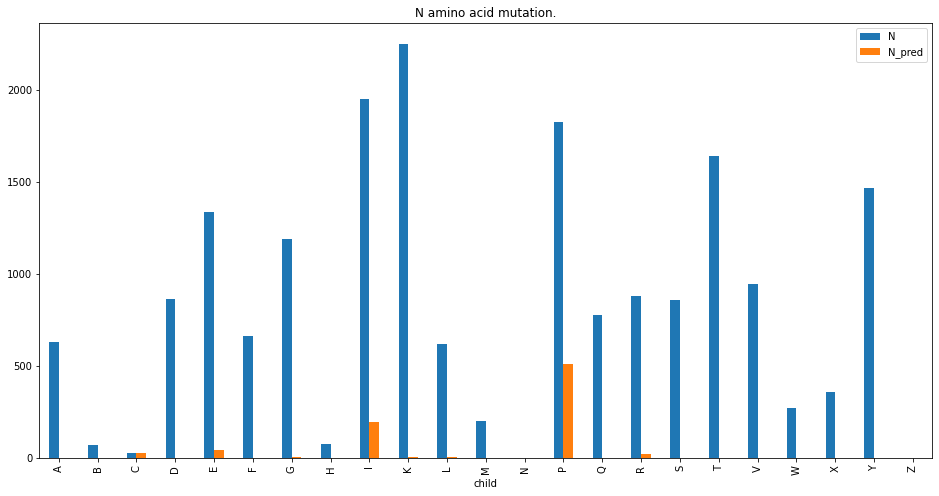

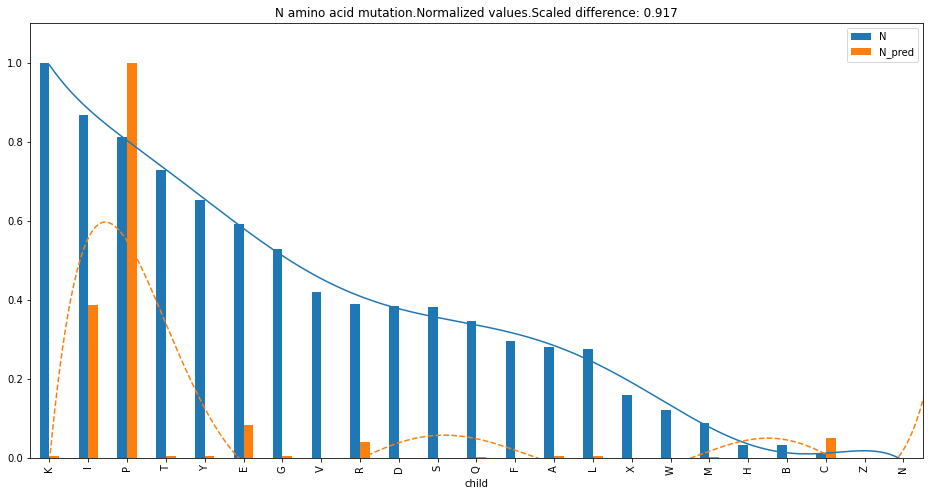

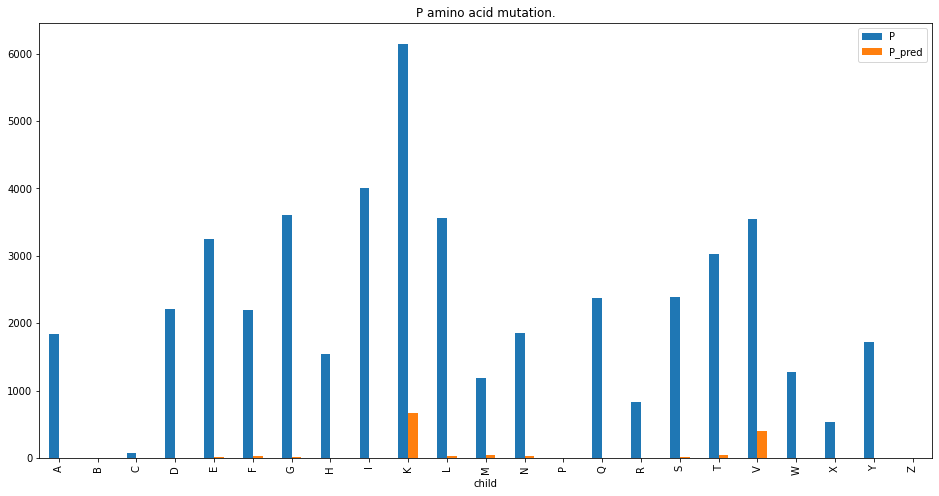

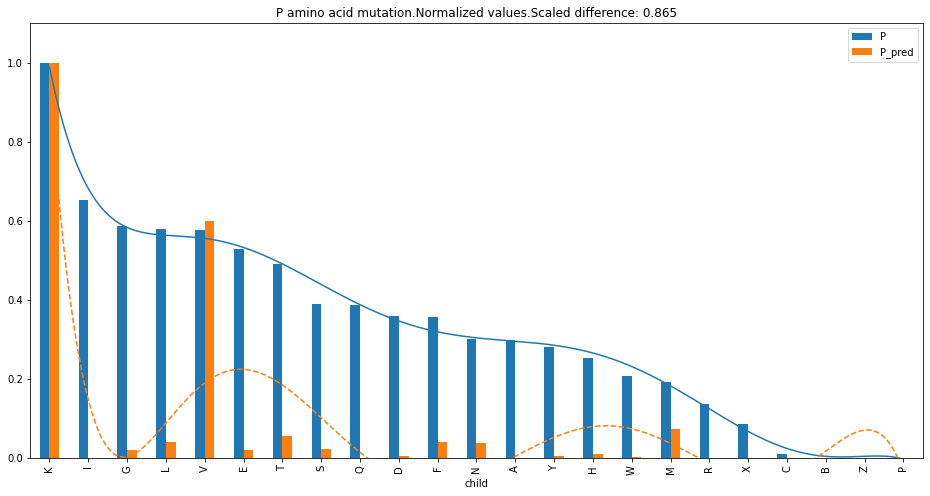

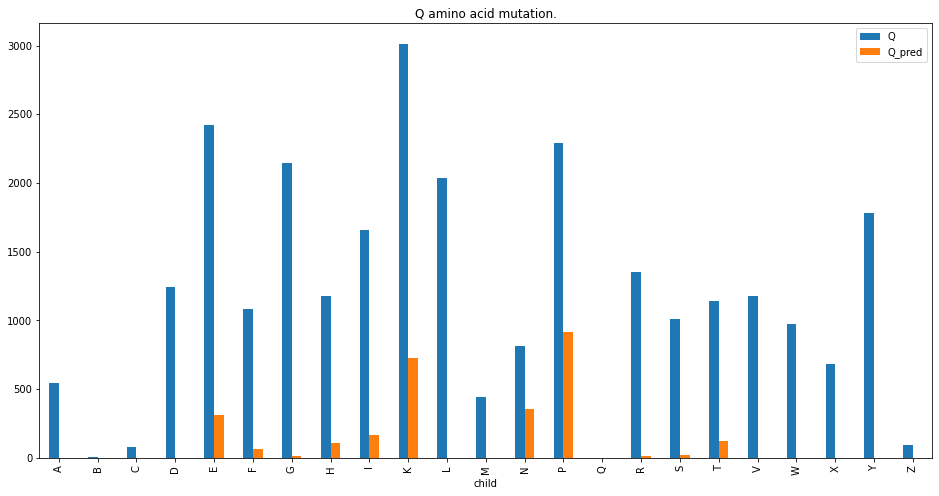

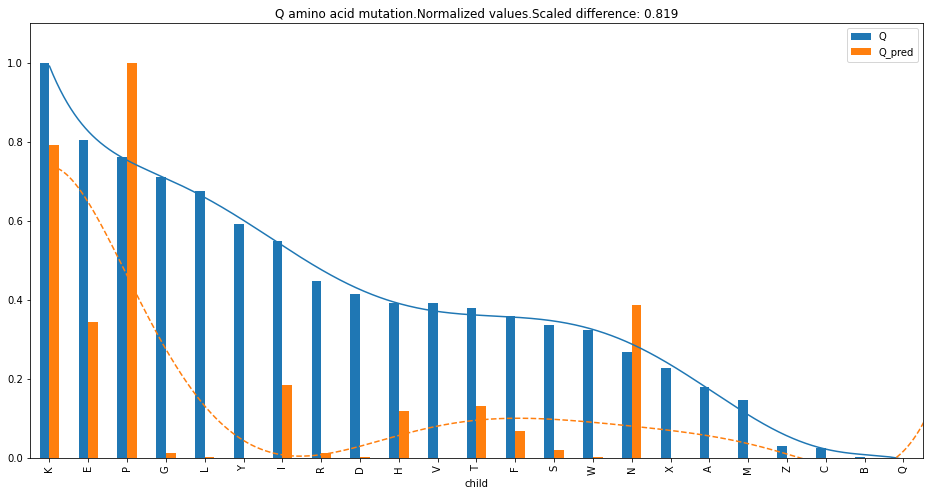

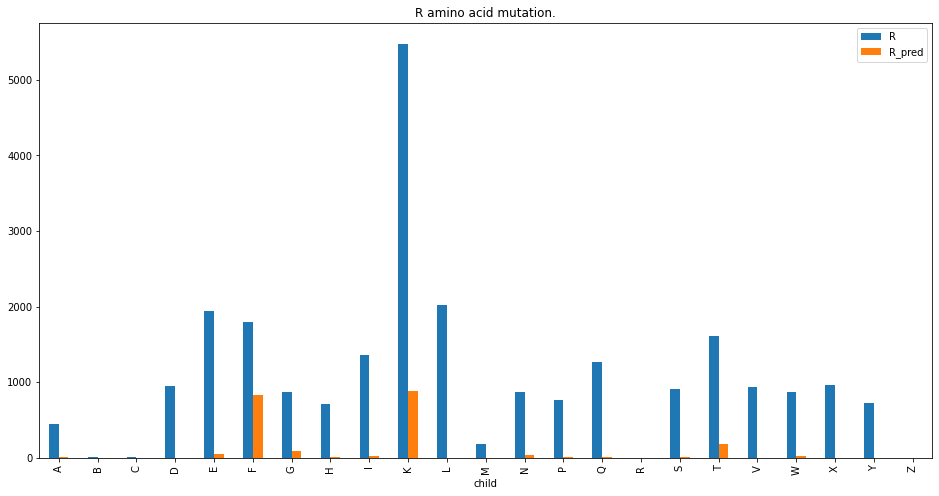

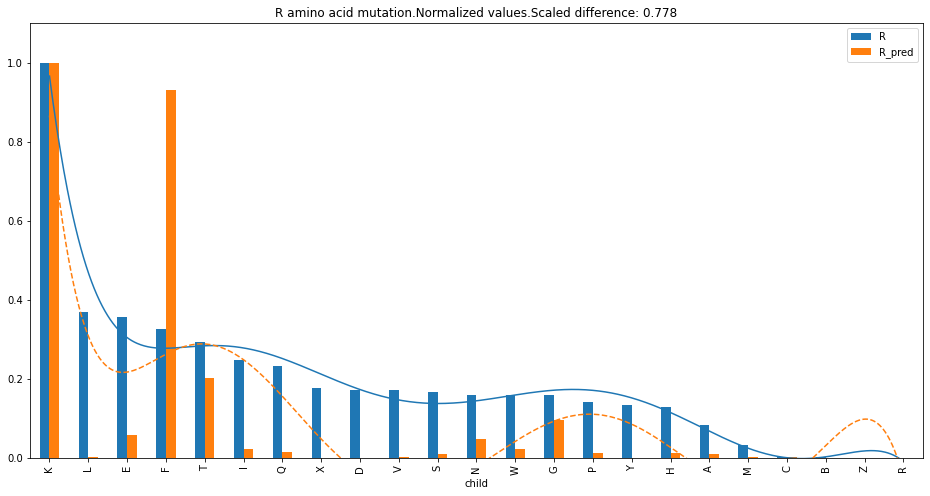

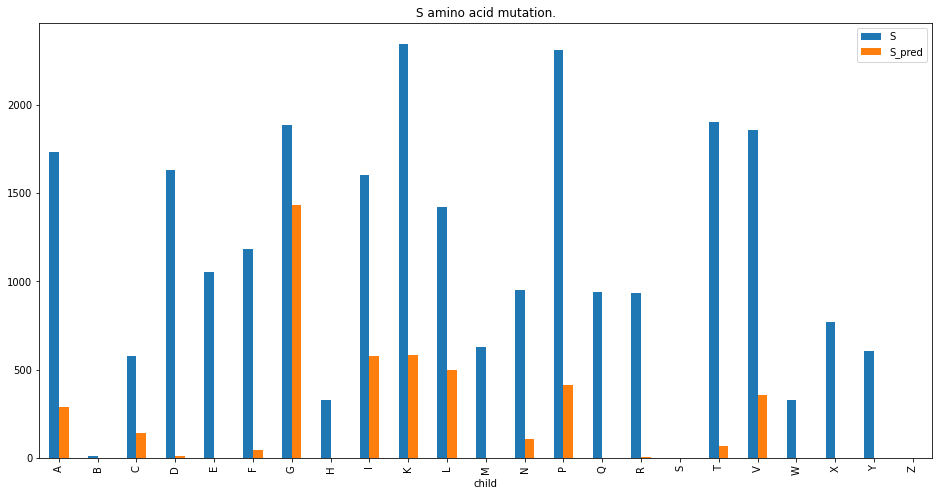

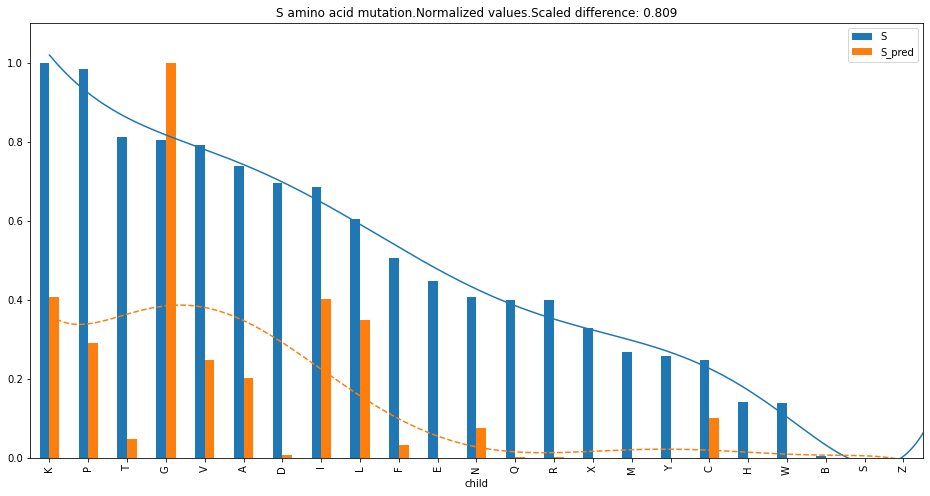

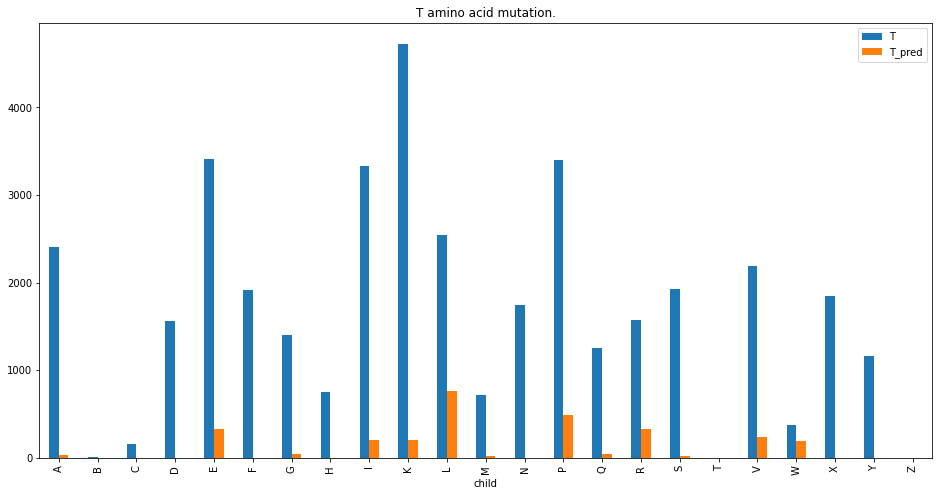

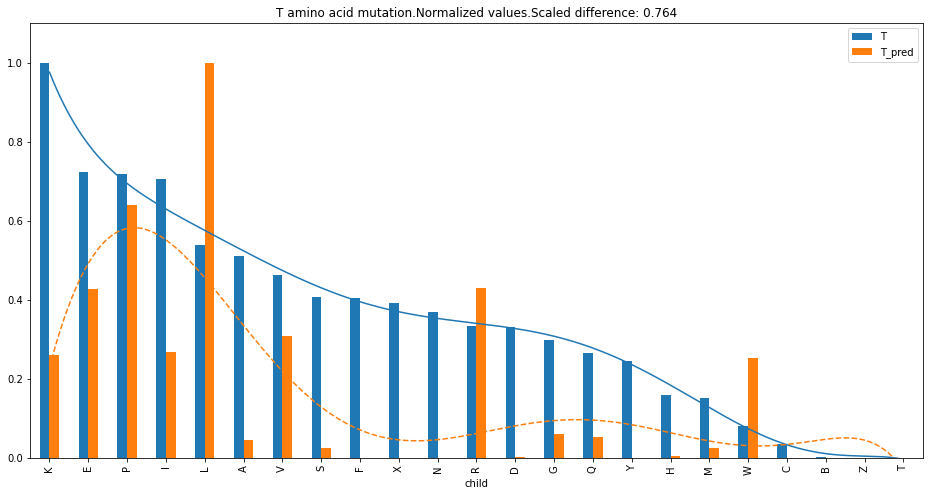

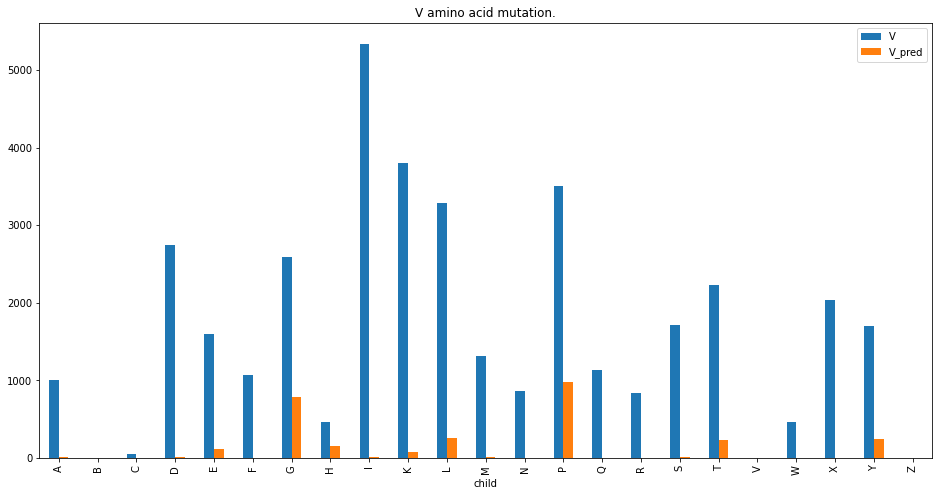

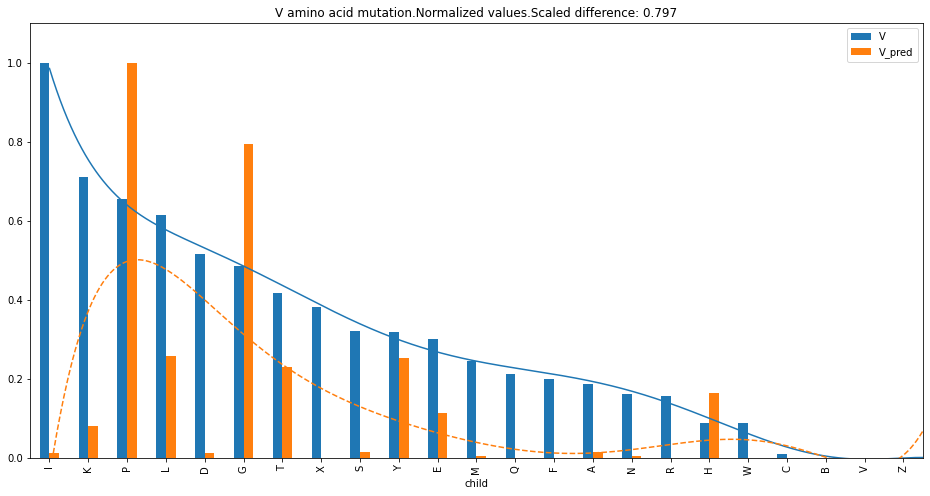

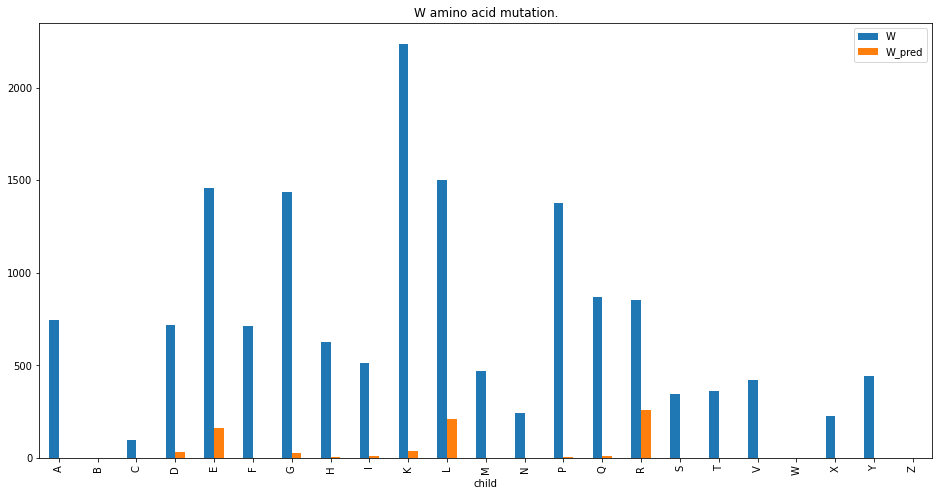

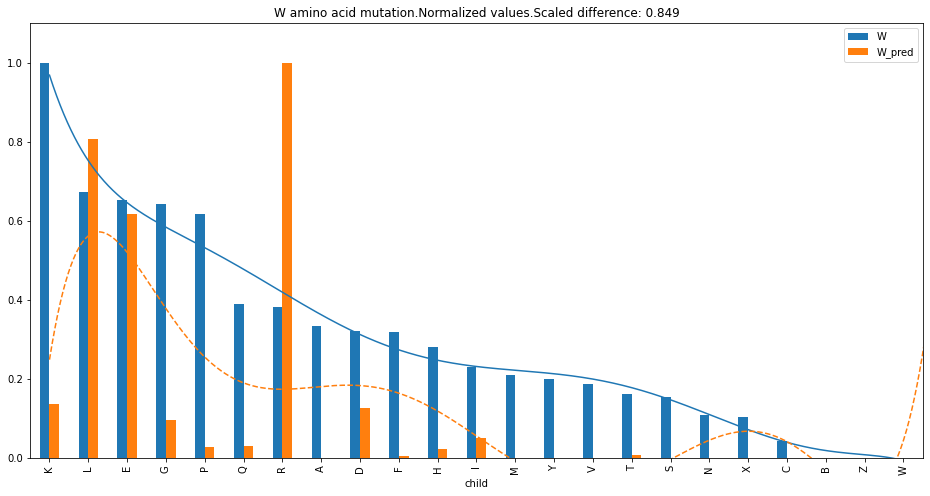

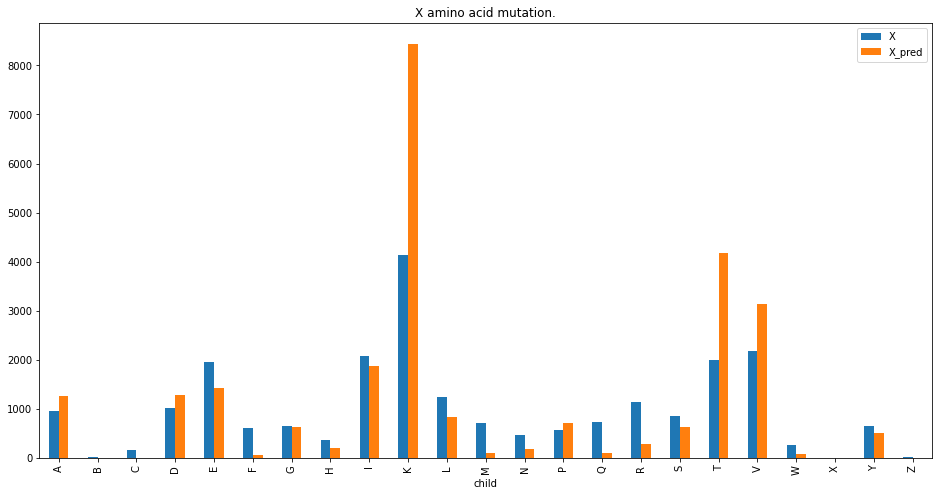

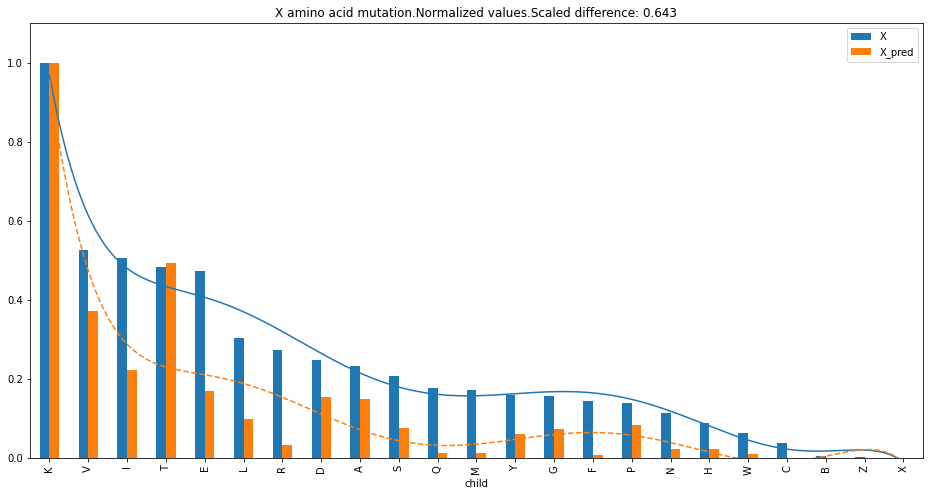

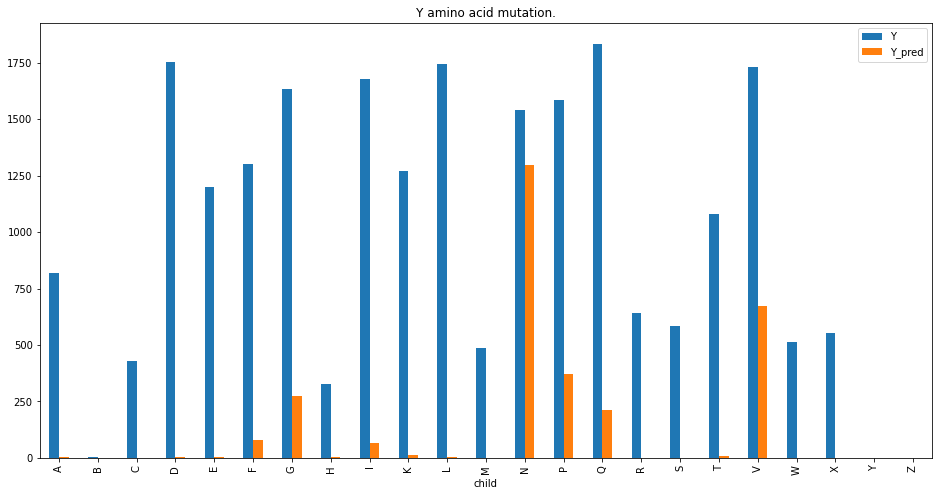

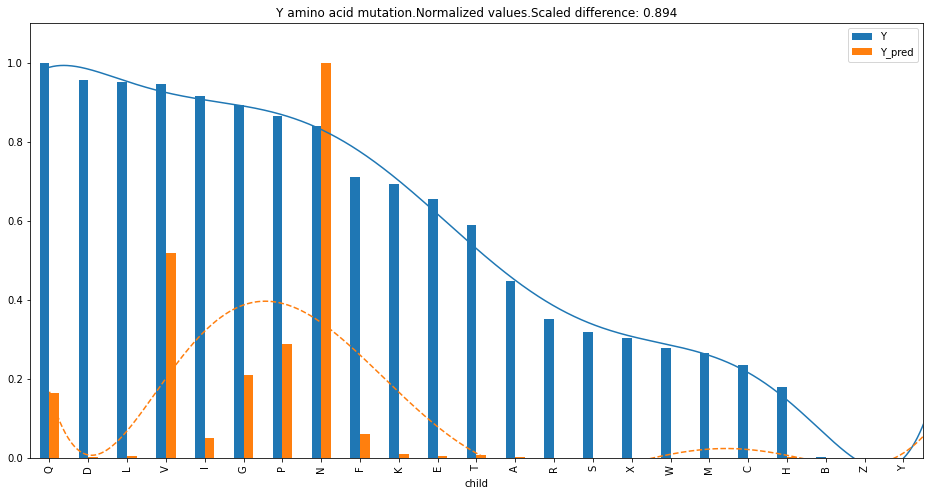

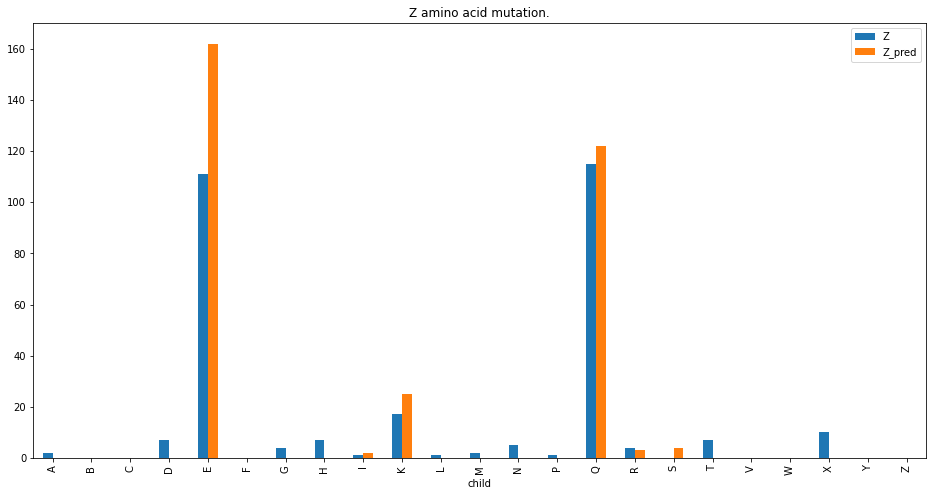

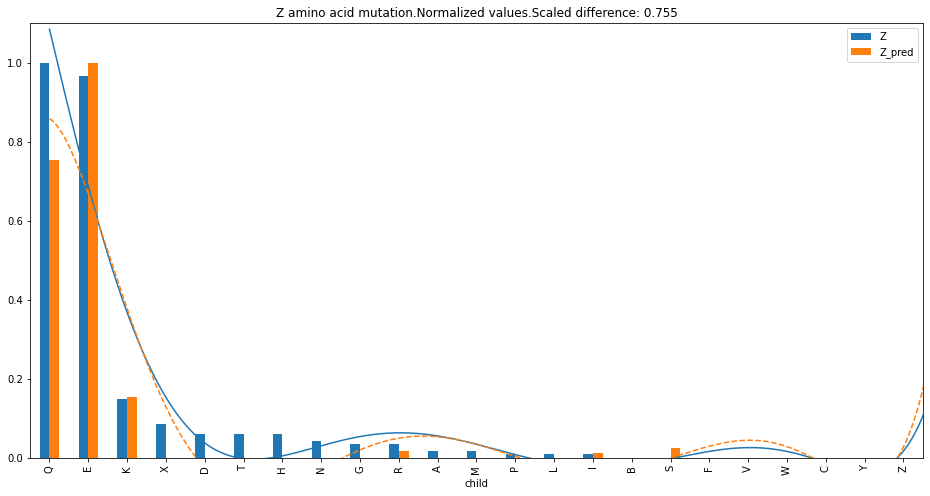

In [50]:
for key in V:
    plot(df_true_frequencies, df_pred_frequencies, key)
    plot(df_true_frequencies, df_pred_frequencies, key, normalize=True, sort=True, polyorder = 7)


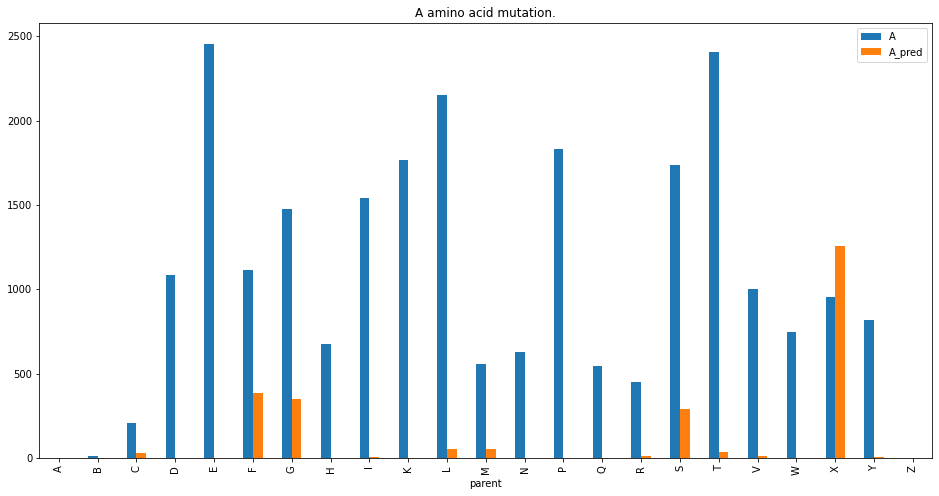

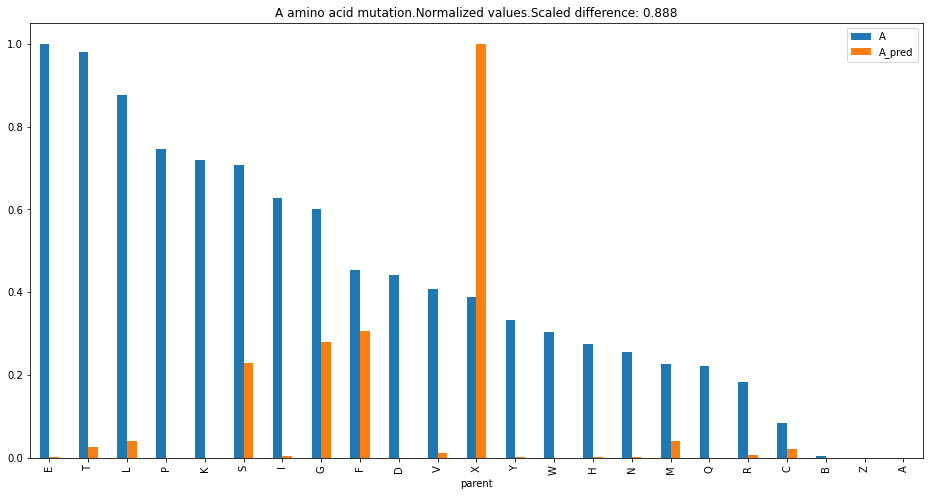

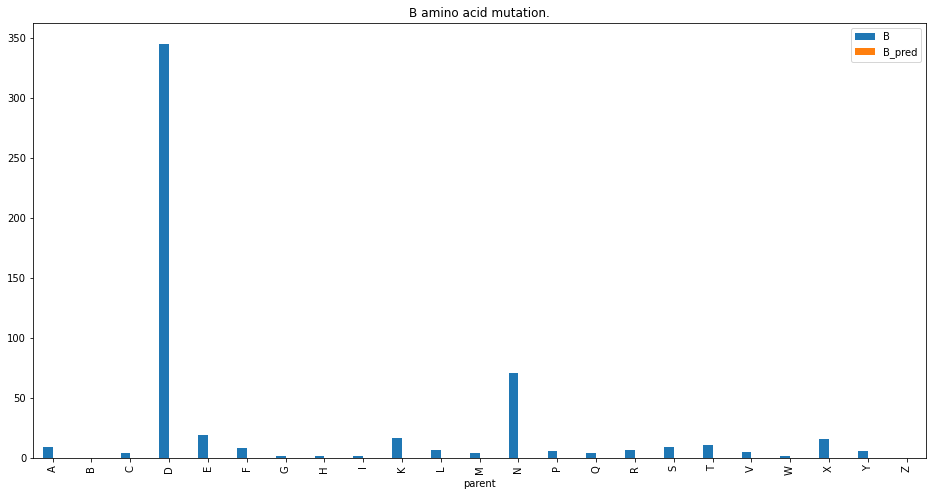

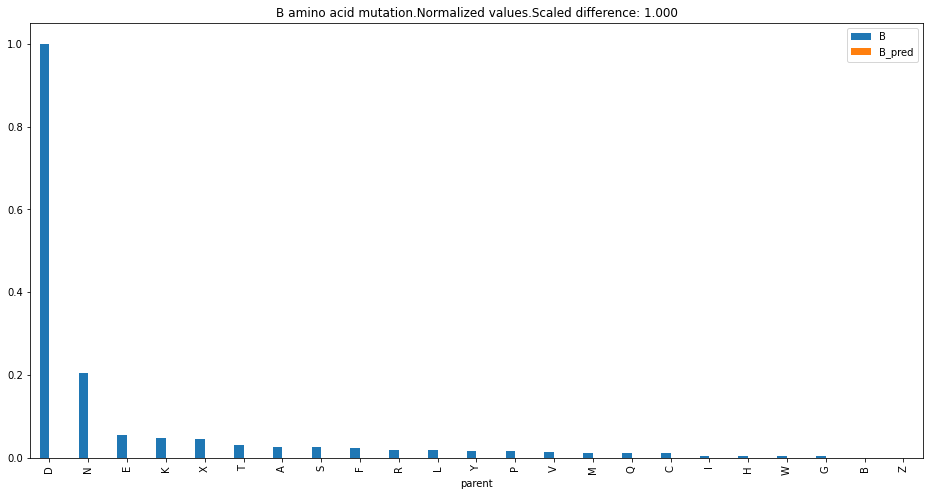

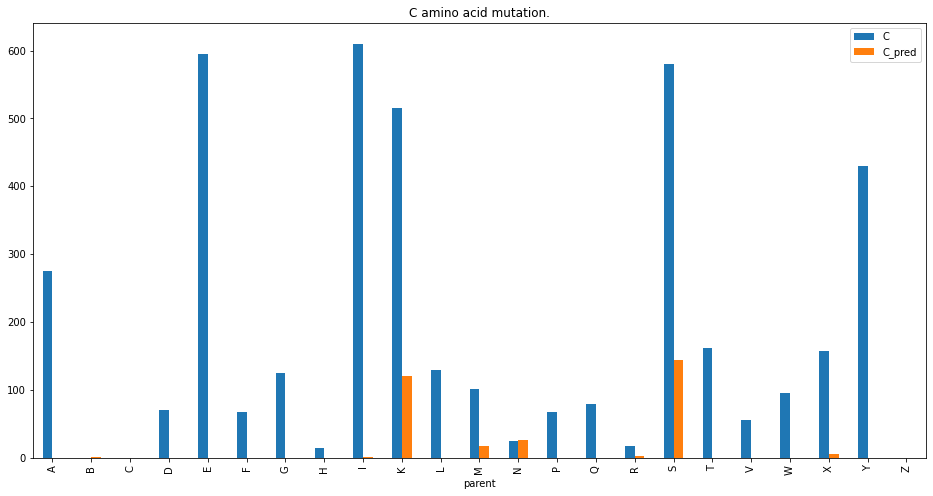

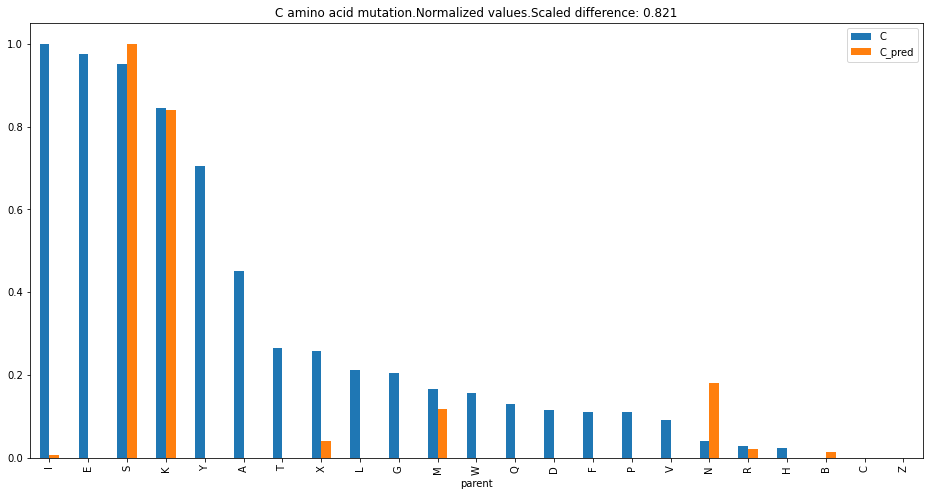

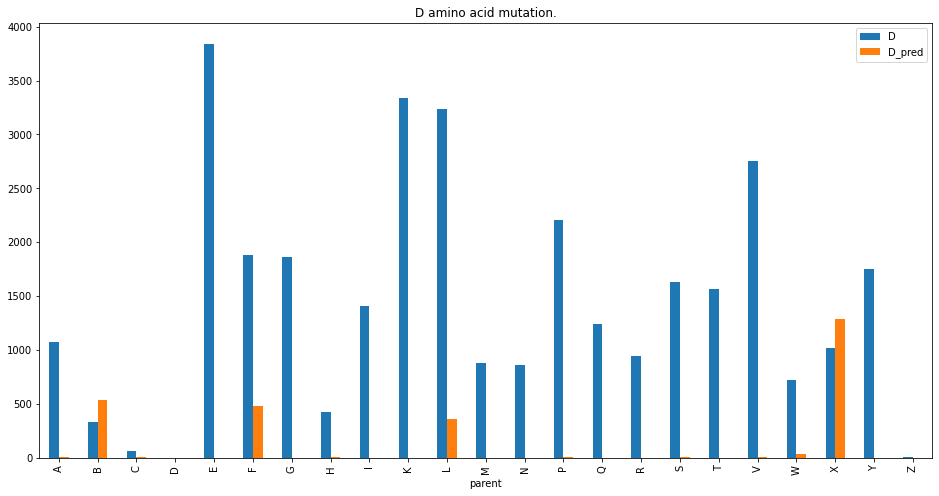

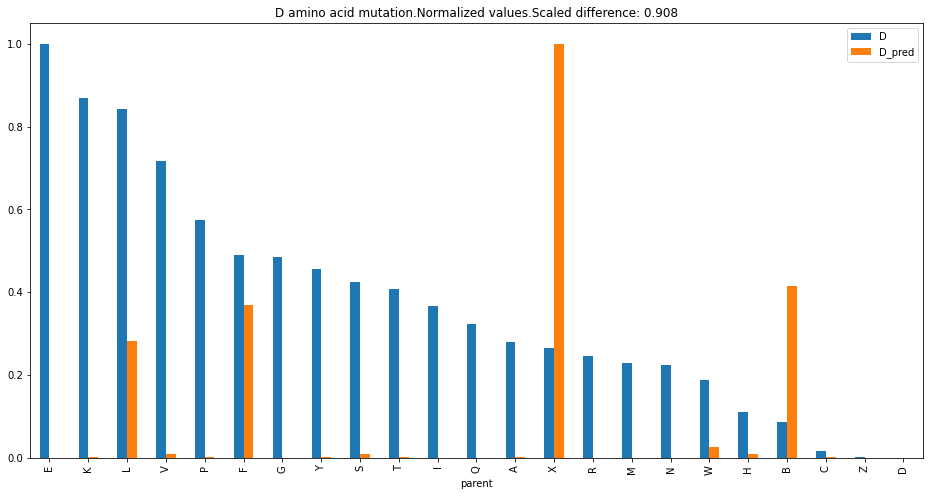

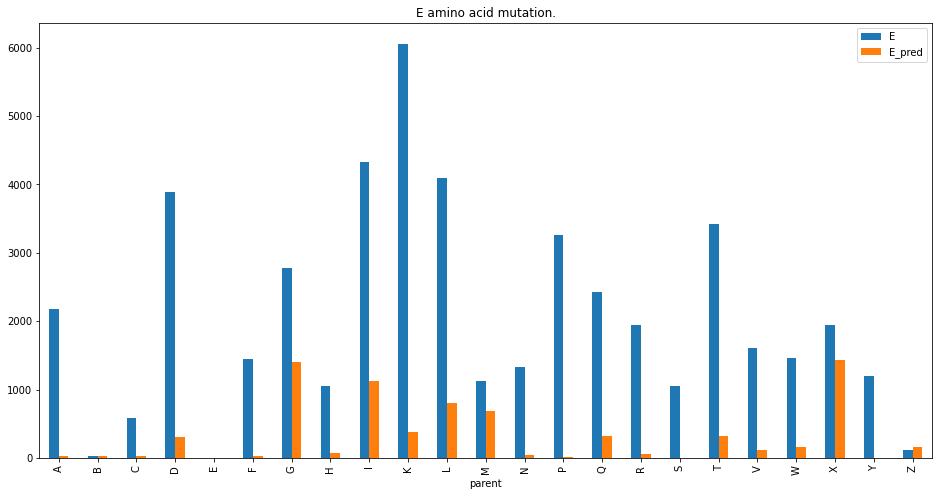

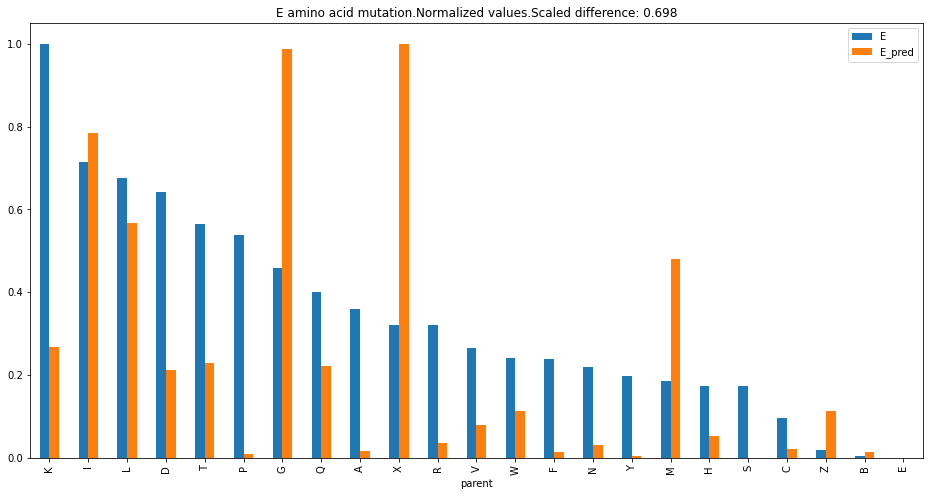

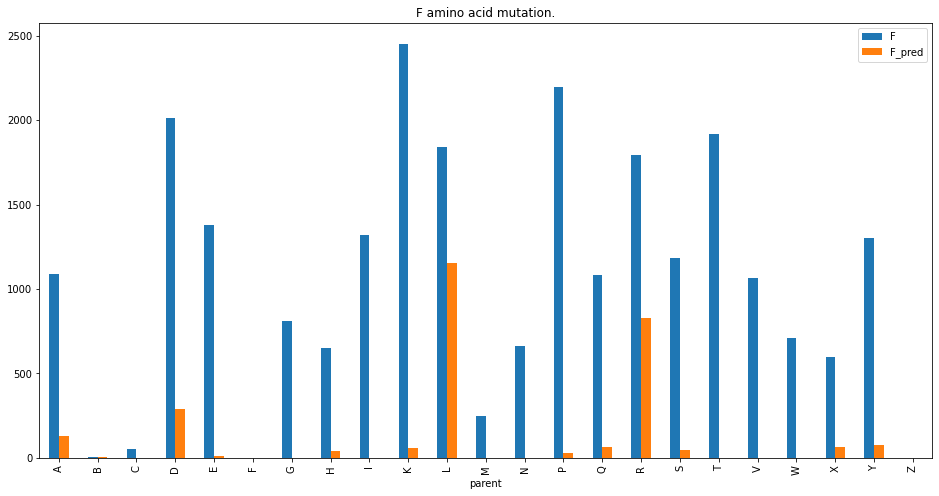

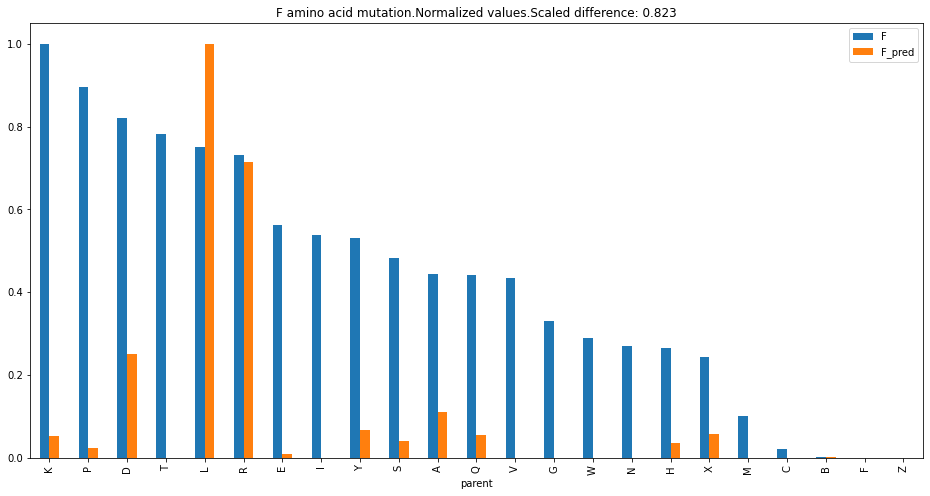

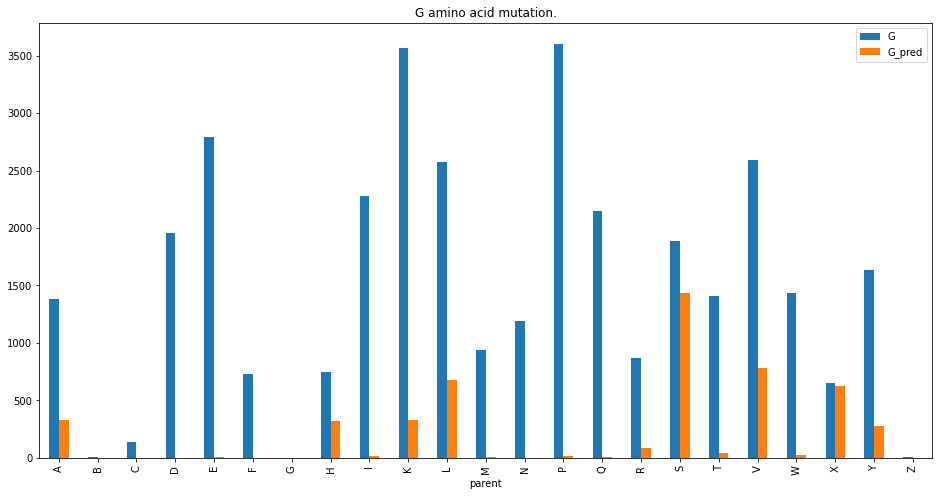

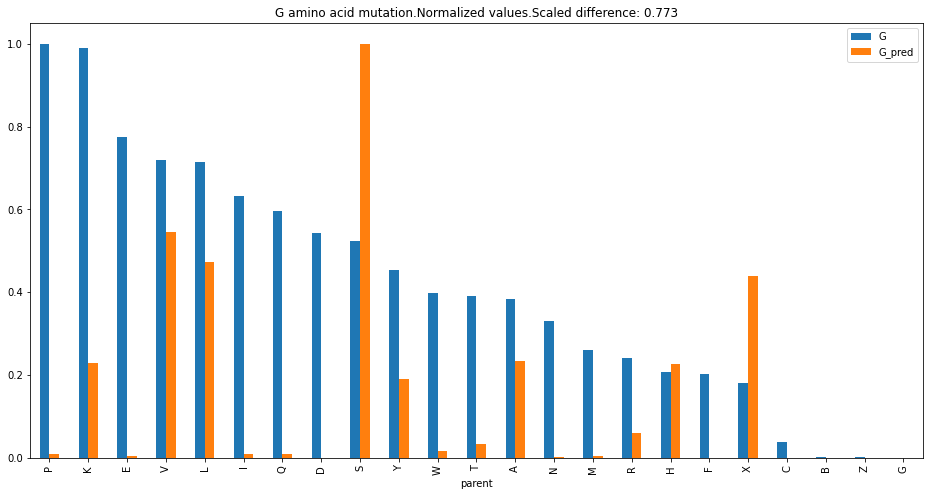

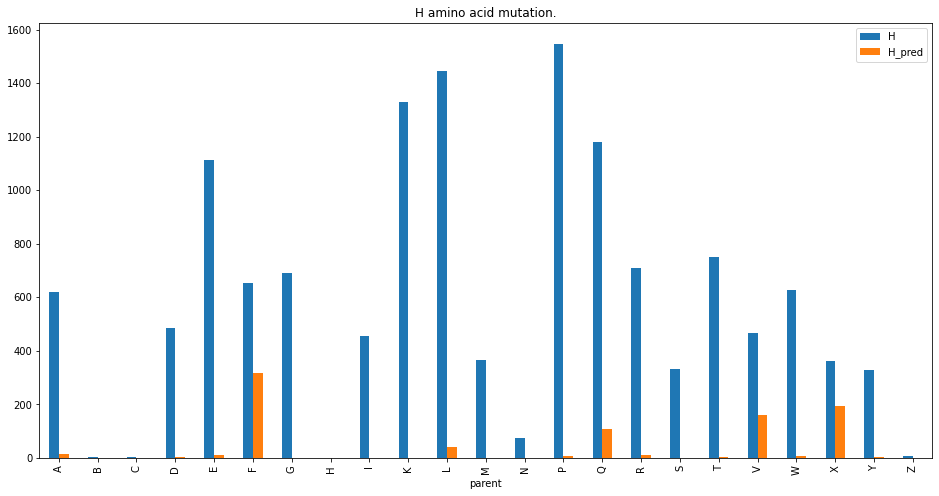

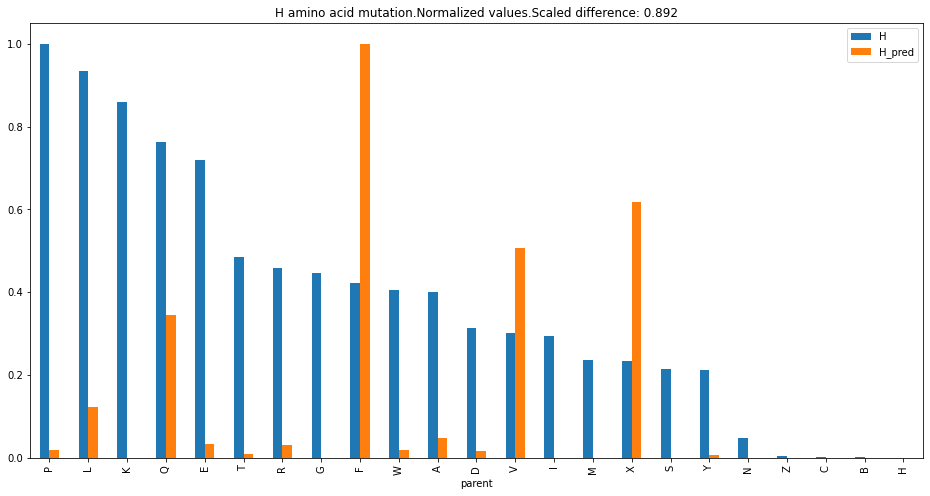

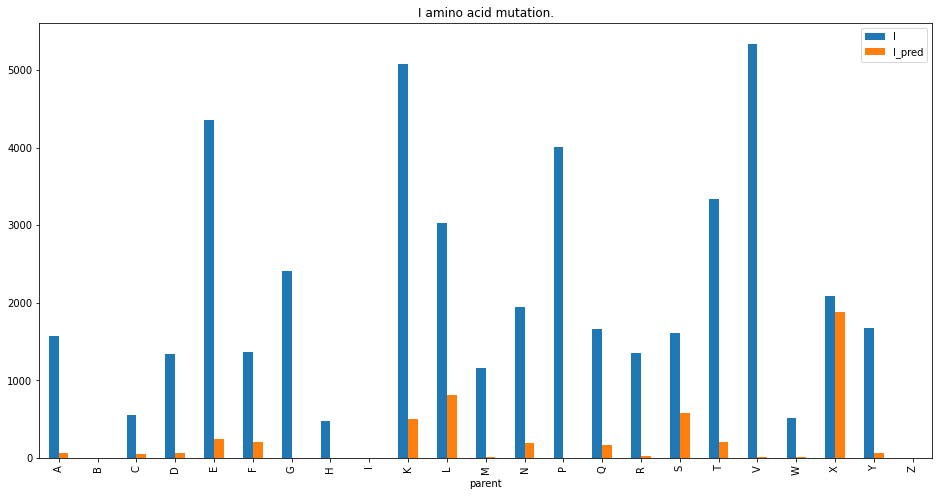

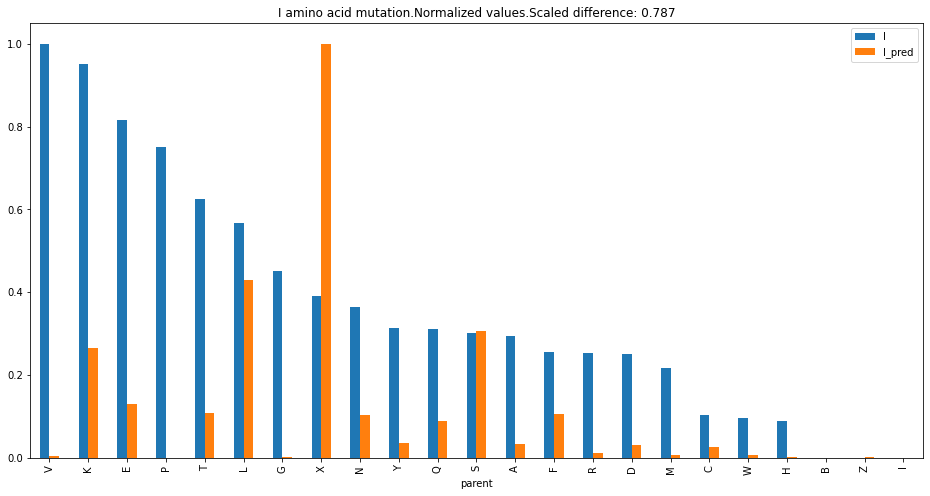

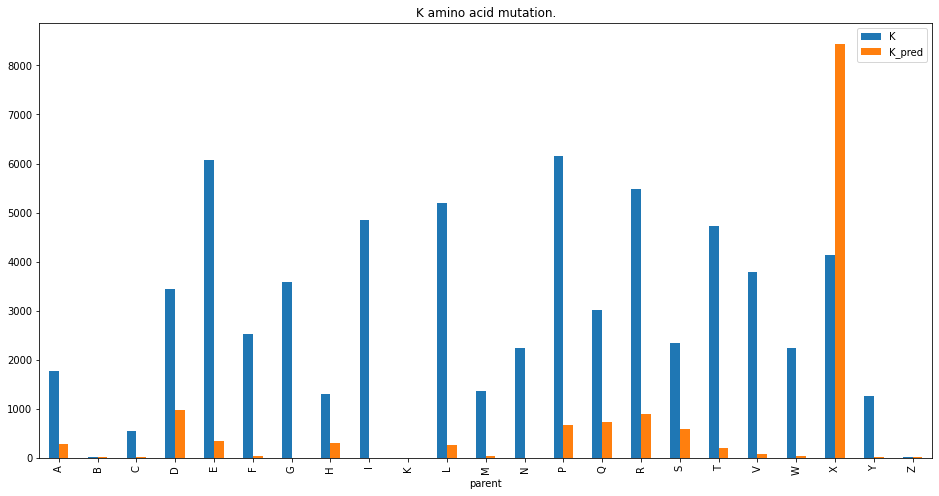

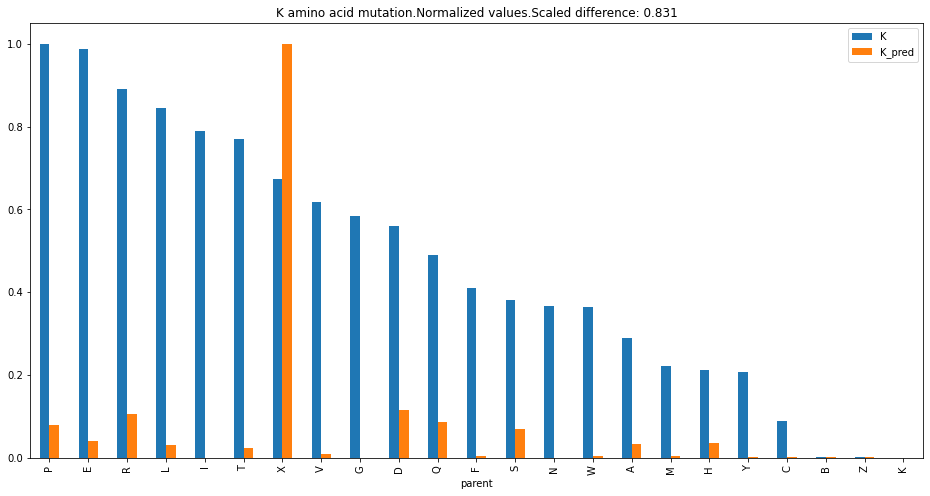

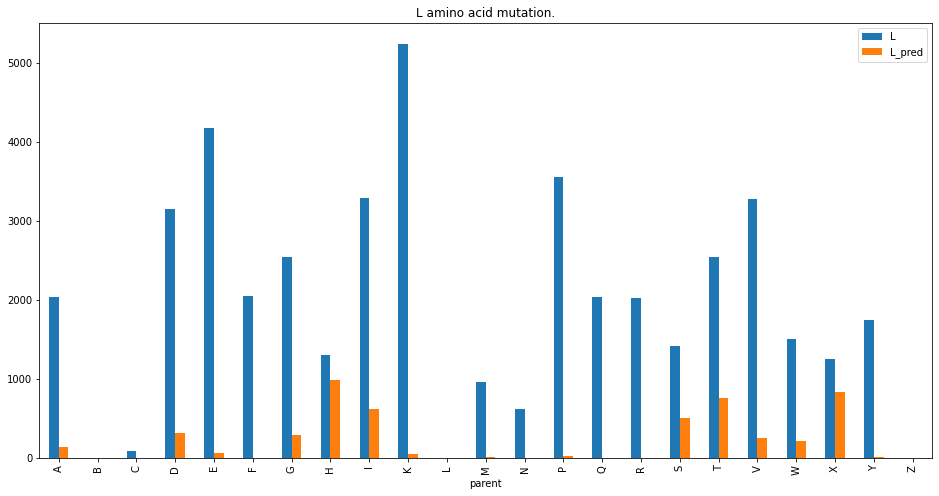

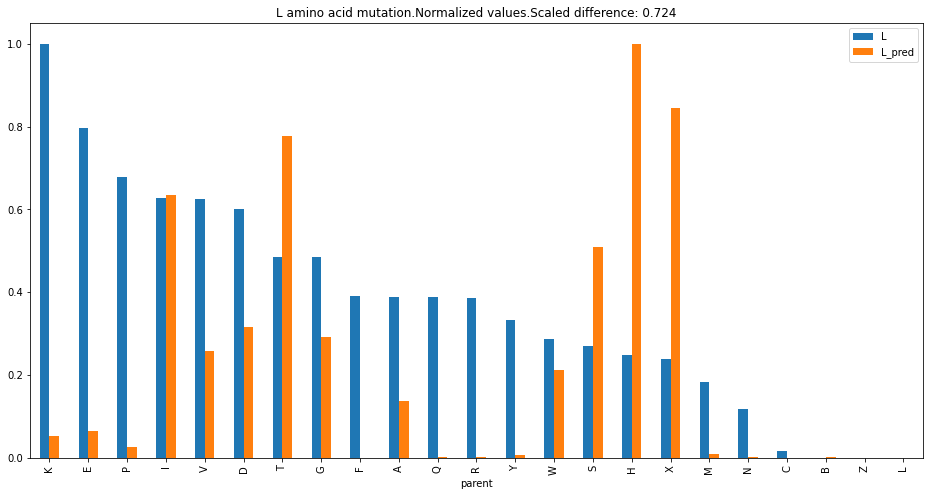

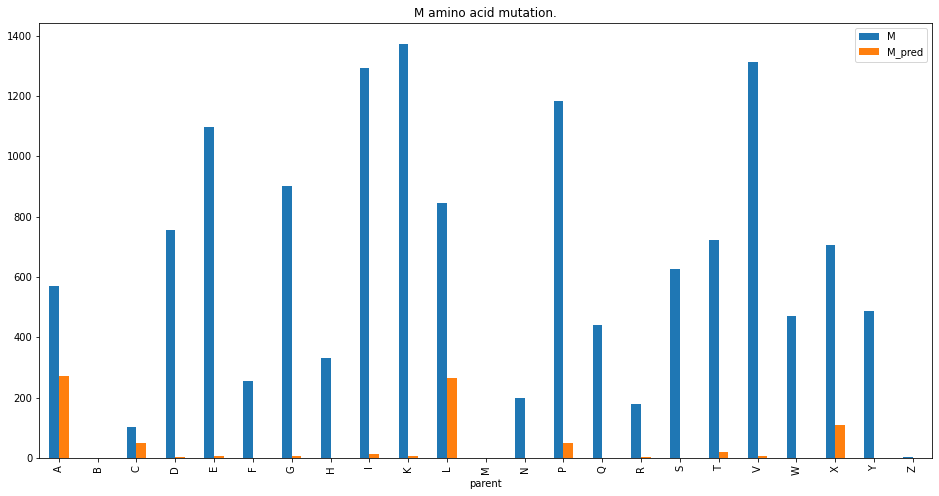

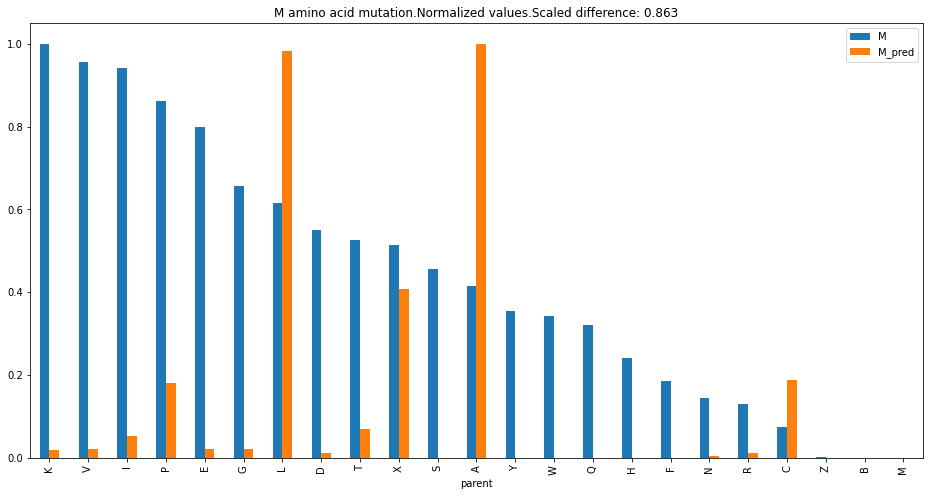

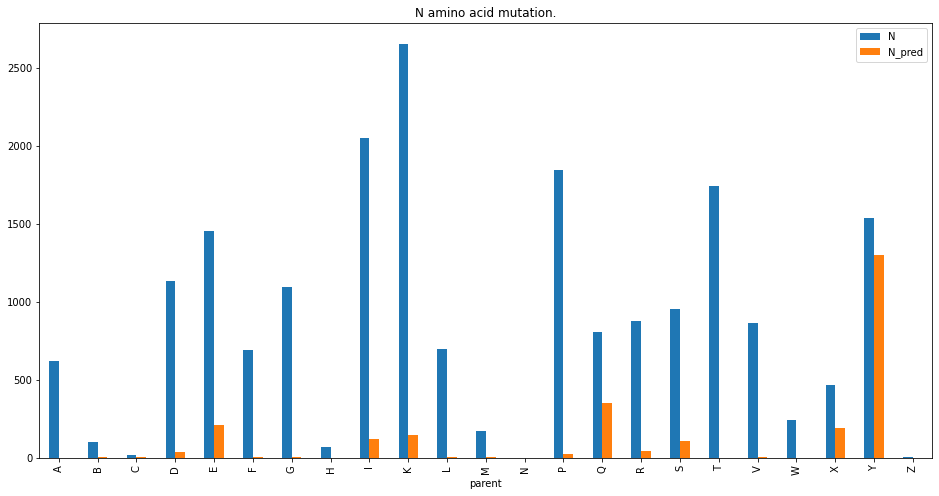

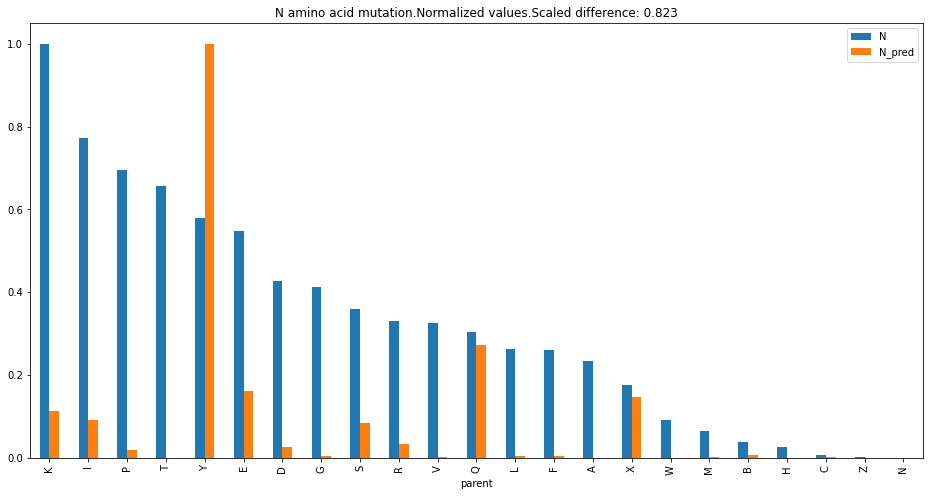

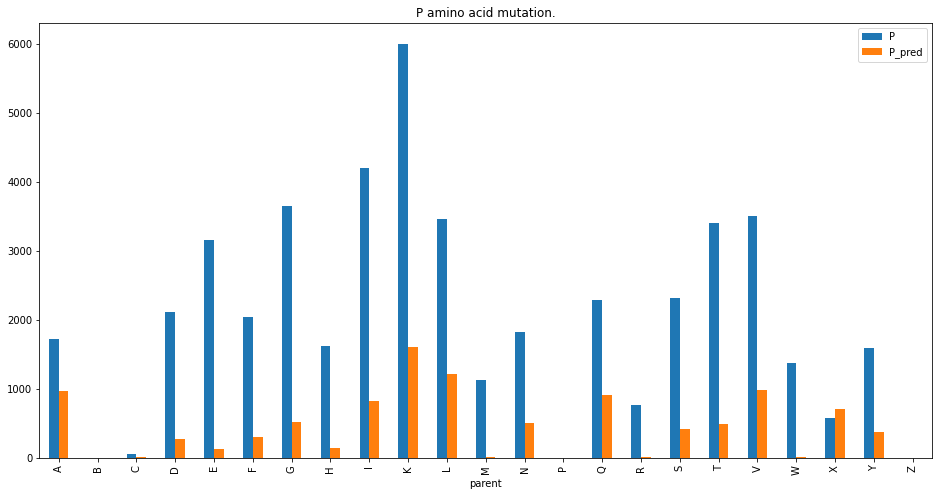

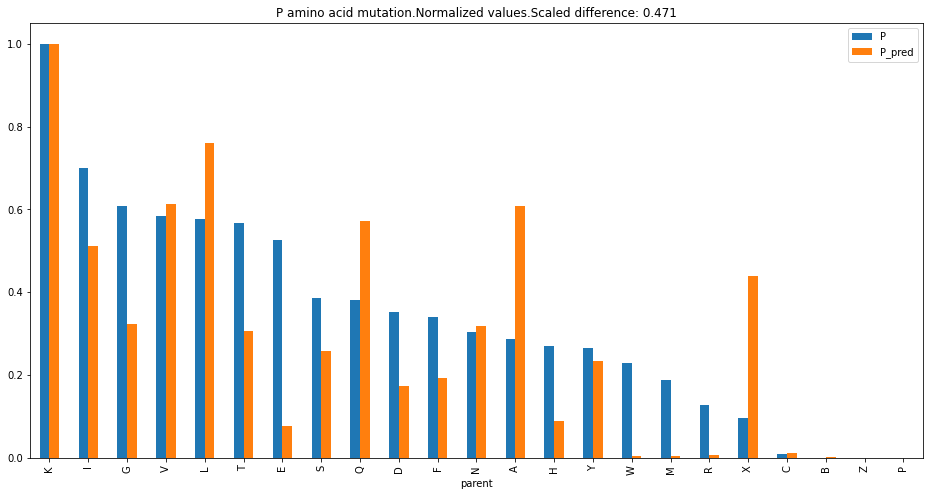

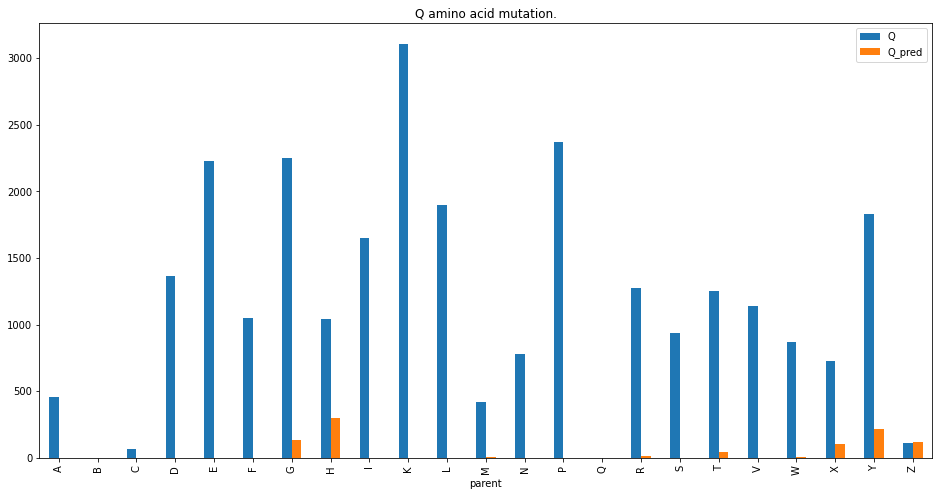

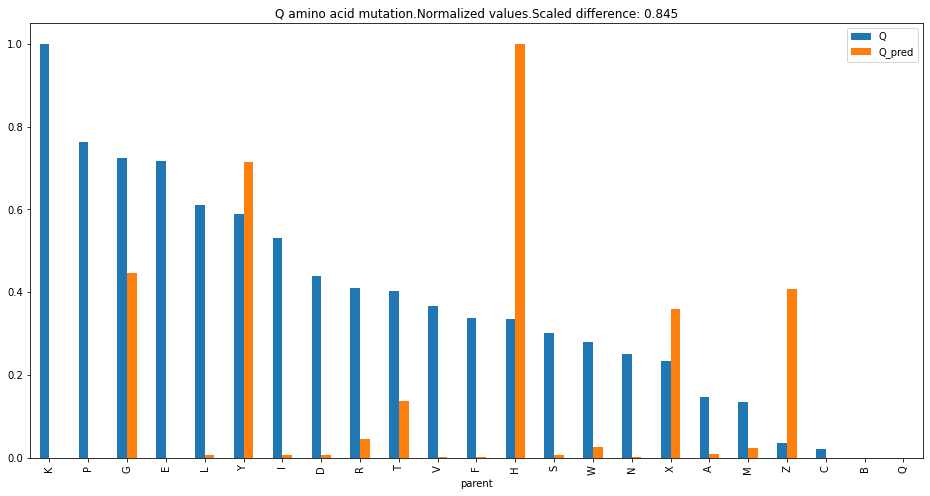

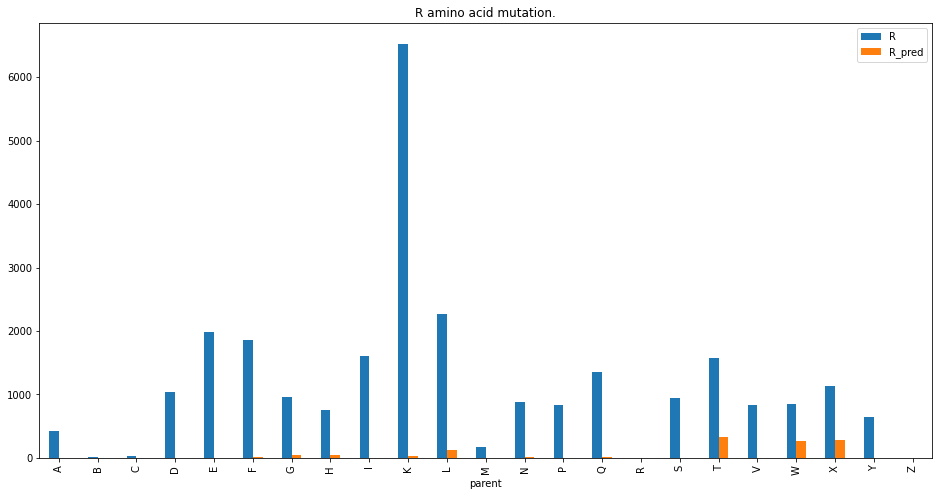

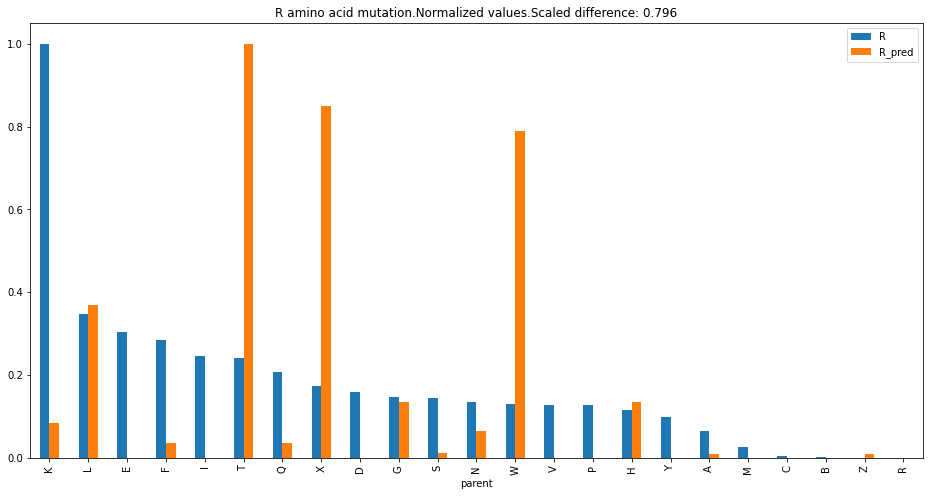

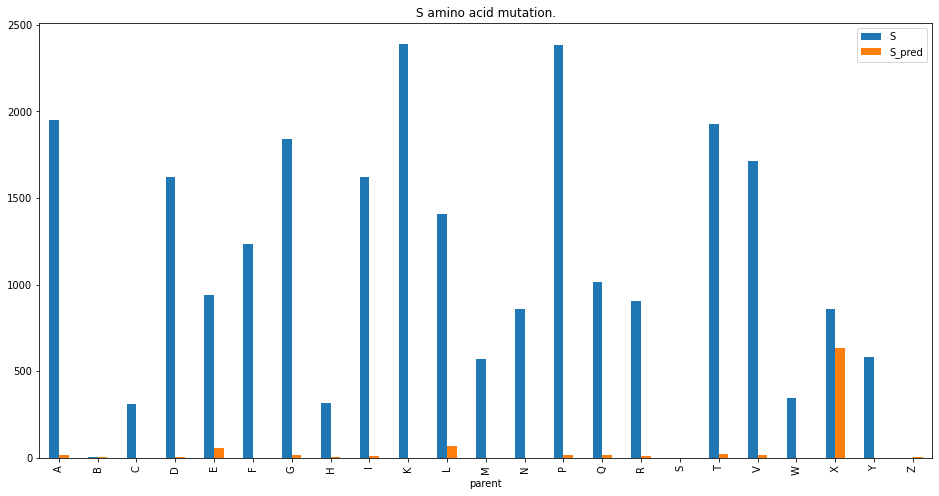

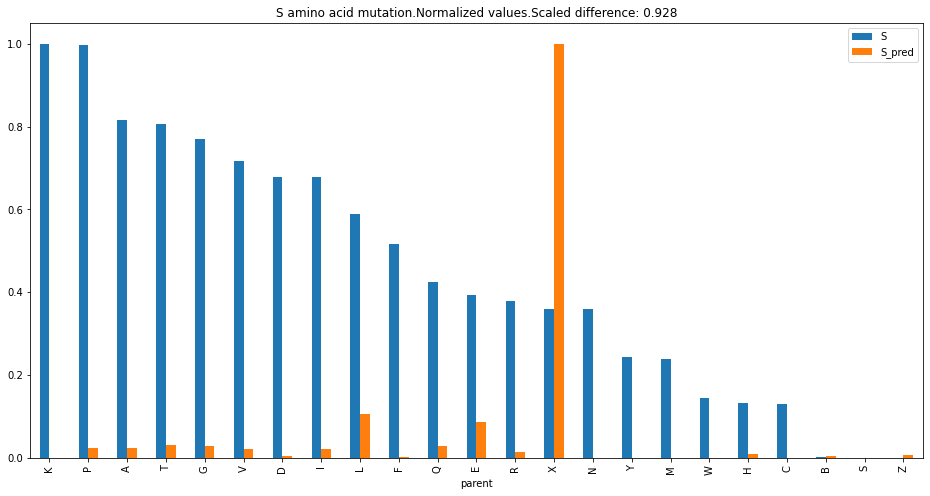

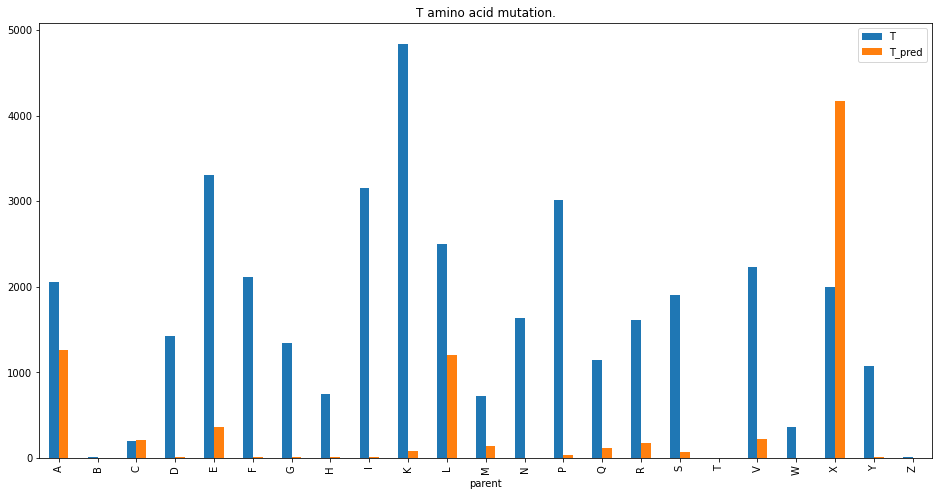

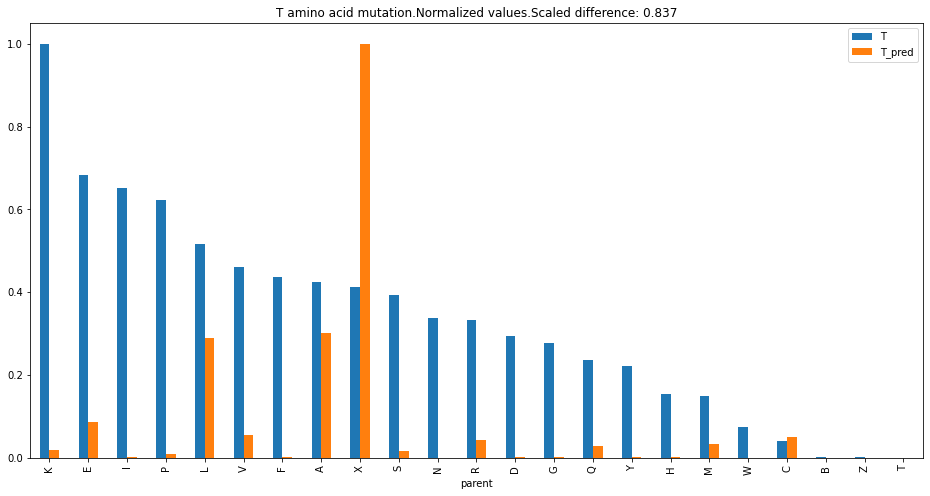

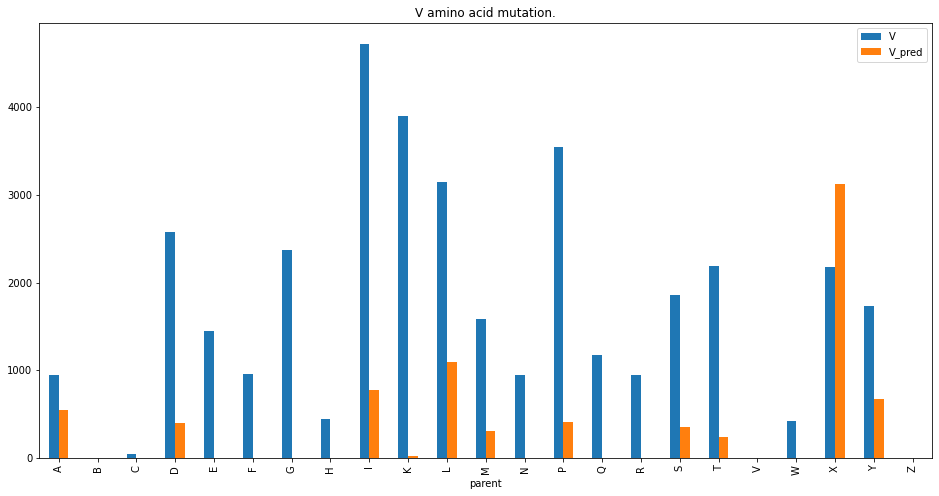

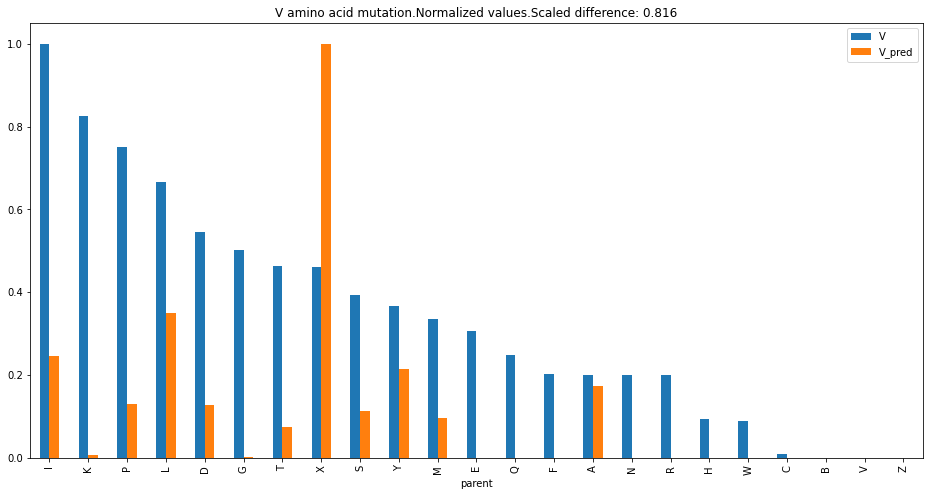

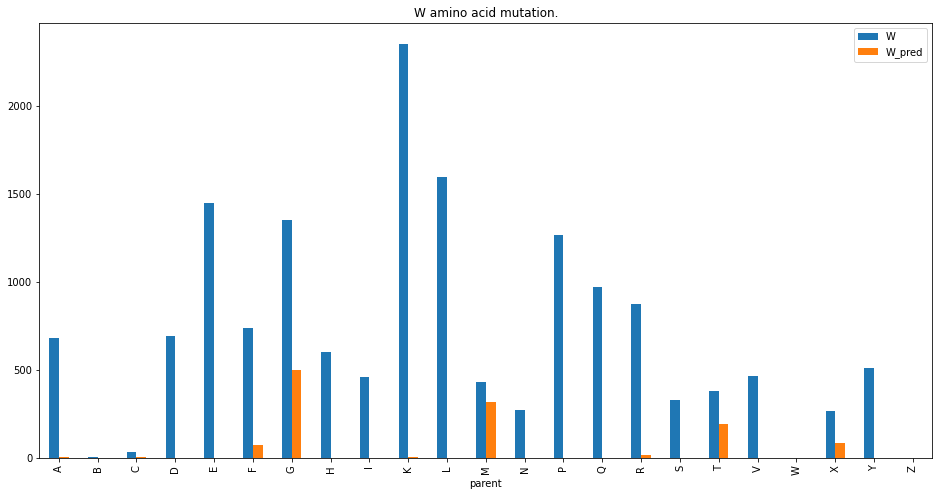

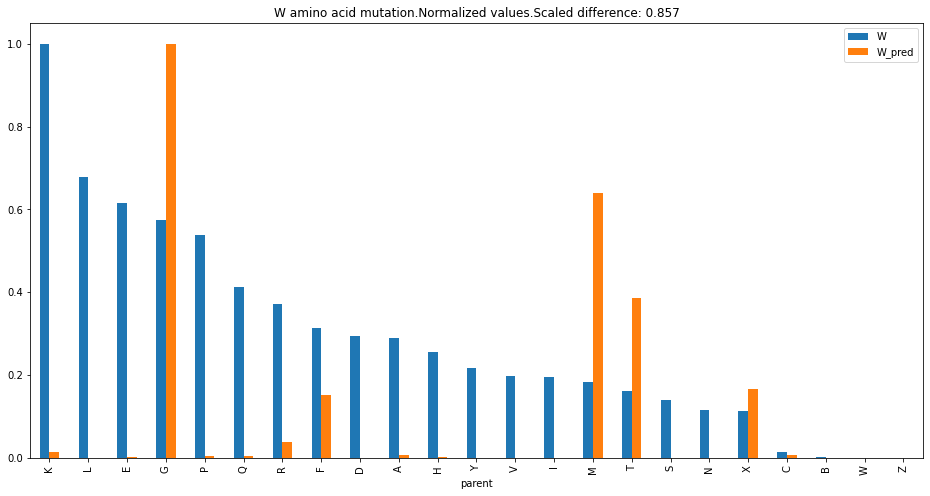

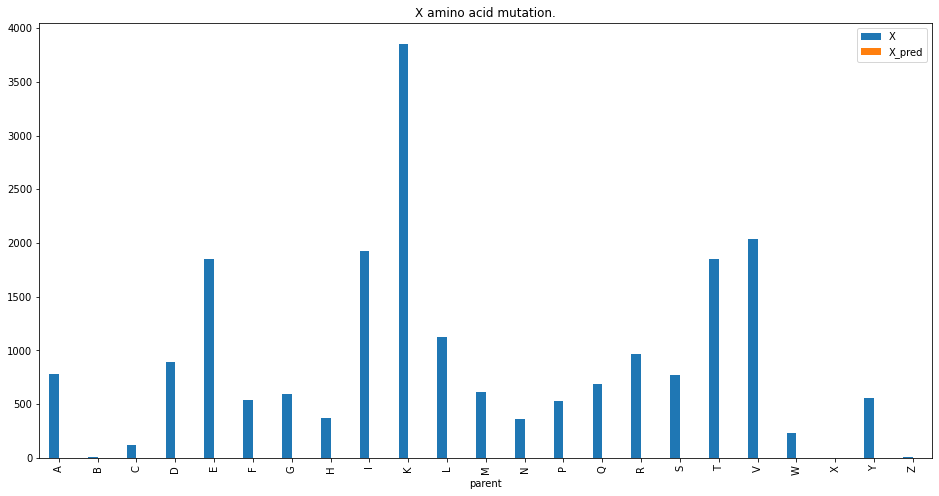

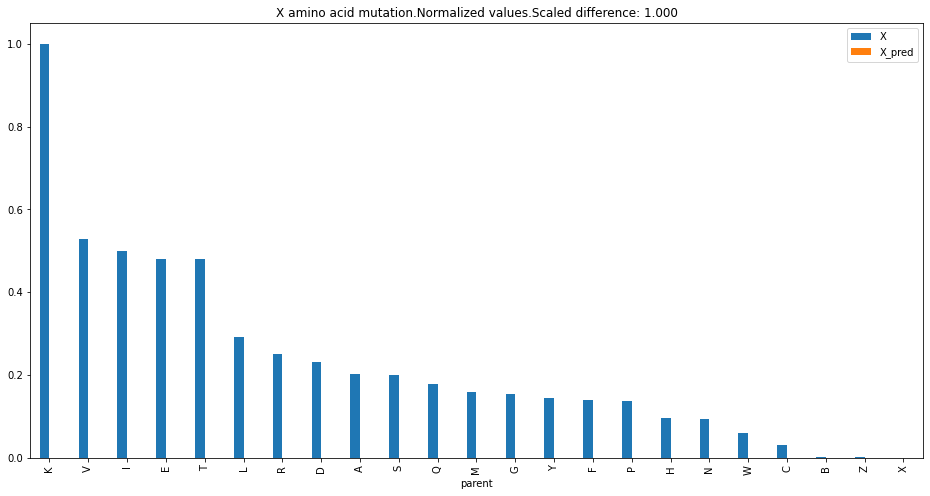

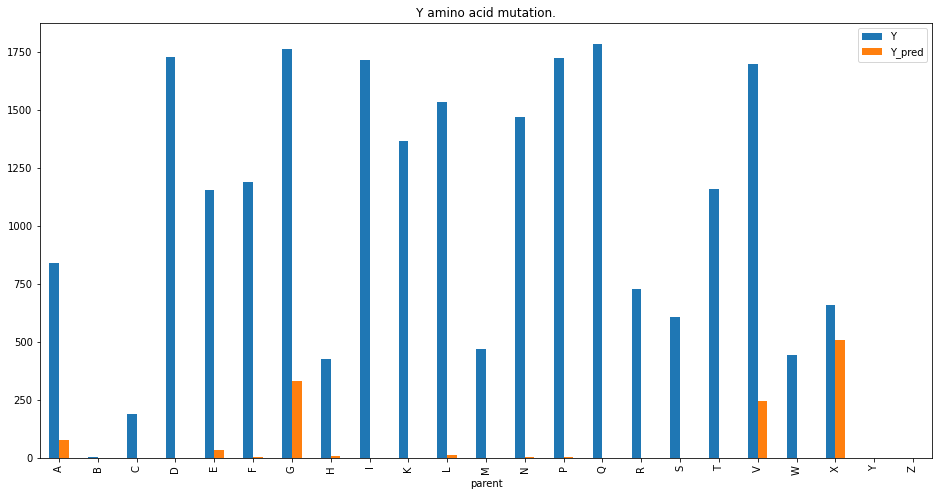

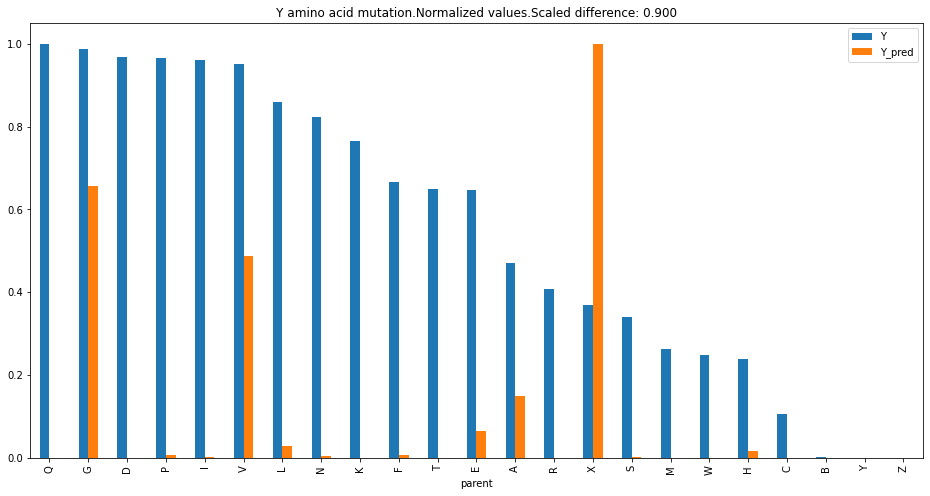

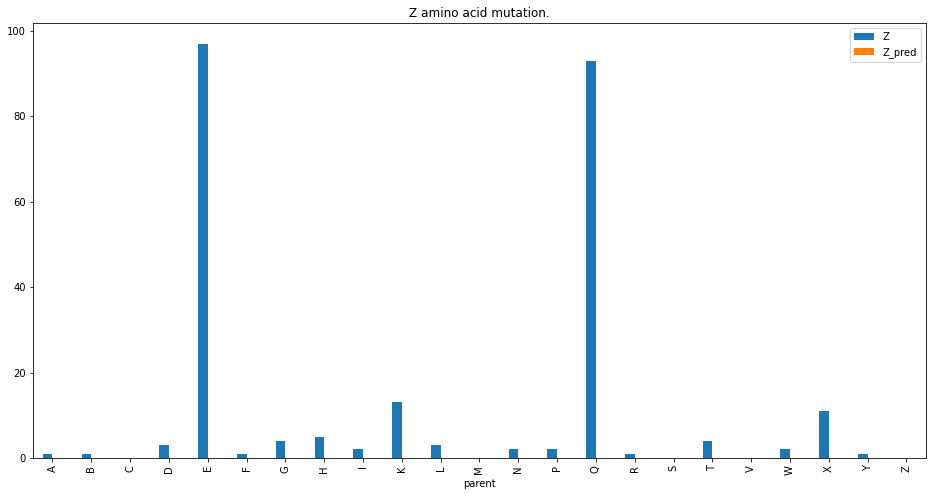

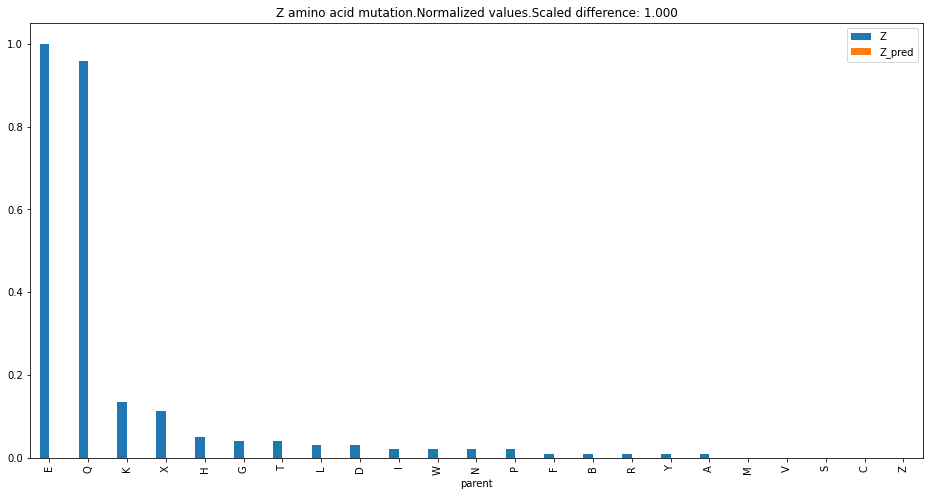

In [51]:
for key in V:
    plot(df_true_frequencies.T, df_pred_frequencies.T, key)
    plot(df_true_frequencies.T, df_pred_frequencies.T, key, normalize=True, sort=True)